In [1]:
import preprocessor, league_table, soccer_model

In [159]:
import math
import numpy as np
import pandas as pd
from itertools import cycle
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)

from scipy import interp
import scipy.stats as scs
import statsmodels.api as sm
from scipy.spatial.distance import cdist

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.cluster import KMeans


import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
%config InlineBackend.figure_format='retina'

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [3]:
%run preprocessor.py

Enter path to file that you wish to preprocess: (should be a .csv file) ../data/FootballEurope/FootballEurope.csv


/Users/CEO/anaconda3/lib/python3.6/site-packages/IPython/utils/py3compat.py:188: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(compiler(f.read(), fname, 'exec'), glob, loc)


In [4]:
clean_df = preprocessor.create_model_df('../data/FootballEurope/FootballEurope.csv')

/Users/CEO/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2961: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
clean_df.head(1)

,awayDispossessedFT,awayPassSuccessFT,awayRatingsFT,awayDribbleSuccessFT,homeFoulsCommitedFT,homeAerialsTotalFT,awayShotsOnTargetFT,awayShotsBlockedFT,homePassesKeyFT,awayDribblesWonFT,homeCornersTotalFT,homeShotsBlockedFT,homeDribbleSuccessFT,awayAerialsTotalFT,awayPassesKeyFT,homeFormation,refereeName,homePossessionFT,awayInterceptionsFT,homeDribbledPastFT,homeDribblesWonFT,awayTackleSuccessFT,awayTeam,homeDispossessedFT,awayOffsidesCaughtFT,awayDribbledPastFT,awayFormation,homeShotsTotalFT,homePassSuccessFT,awayCornersTotalFT,homeTeam,awayFoulsCommitedFT,homeShotsOnTargetFT,homeTacklesTotalFT,homeOffsidesCaughtFT,venueName,awayDribblesAttemptedFT,homeInterceptionsFT,awayTacklesTotalFT,homeRatingsFT,homeDribblesAttemptedFT,homeTackleSuccessFT,awayPossessionFT,awayShotsTotalFT,resultsLabel
0,14.0,73.69,6.38,47.22,12,22,2.0,4.0,14,10.0,7.0,4.0,38.89,22,9.0,2,17,47.65,34,10.0,5.0,75.0,13,6,5.0,5.0,0,21,66.73,4.0,1,11,10.0,34,2.0,7,20,21,18,6.73,12.0,75.0,52.35,11.0,1


In [6]:
qwert = pd.read_csv('../data/FootballEurope/FootballEurope.csv')

/Users/CEO/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
qwert.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 94 columns):
Unnamed: 0                 9127 non-null int64
id                         9127 non-null int64
homeTacklesTotalHT         9127 non-null int64
homeShotsTotalHT           9127 non-null int64
awayDispossessedFT         9126 non-null float64
awayPassSuccessFT          9127 non-null float64
awayRatingsFT              9127 non-null float64
awayDribbleSuccessFT       9125 non-null float64
awayDribblesAttemptedHT    9127 non-null int64
awayTeamLineUp             9127 non-null object
awayShotsBlockedHT         8906 non-null float64
awayShotsTotalHT           9126 non-null float64
homeDribbleSuccessHT       9124 non-null float64
homeFoulsCommitedFT        9127 non-null int64
homeAerialsTotalFT         9127 non-null int64
homeRatingsHT              9127 non-null float64
awayShotsOnTargetFT        9069 non-null float64
awayShotsBlockedFT         8906 non-null float64
homeInterceptionsHT       

In [8]:
qwertcols = qwert.columns
sorted(qwertcols[[39,61]])

['awayFormation', 'homeFormation']

In [9]:
qwert[sorted(qwertcols[[39,61]])].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9127 entries, 0 to 9126
Data columns (total 2 columns):
awayFormation    9127 non-null object
homeFormation    9126 non-null object
dtypes: object(2)
memory usage: 142.7+ KB


In [10]:
EPLqwert = qwert[qwert.division == 'EPL']

In [11]:
'''
key - group(count) - group description - members of group
    AA(6) - highly attacking - '343', '433','352', '3412', '3142', '4240' 
    AB(5) - attacking - '3421', '4141','3511', '4132', '4312'
    B(4) - balanced - '4231', '442', 41212', '4222',
    BD(3) - defensive -  '451', '4411', '4321'
    DD(3) - highly defensive - '541', '532', '343d'
    
    ({0: 'AA', 1: 'AB', 2: 'B', 3: 'BD', 4: 'DD'},
     {0: 'AA', 1: 'AB', 2: 'B', 3: 'BD', 4: 'DD'})
    '''
EPLqwert[['awayFormation','homeFormation']].tail(8)

,awayFormation,homeFormation
1892,532,4231
1893,4231,4231
1894,3421,442
1895,4231,4231
1896,4411,4141
1897,4231,4141
1898,4231,433
1899,4411,433


In [12]:
clean_df[['awayFormation','homeFormation']].tail(8)

,awayFormation,homeFormation
1892,4,2
1893,2,2
1894,1,2
1895,2,2
1896,3,1
1897,2,1
1898,2,0
1899,3,0


In [13]:
EPLqwert[['awayFormation','homeFormation']].head(8)

,awayFormation,homeFormation
0,343,4231
1,4231,4231
2,4231,4231
3,4231,4231
4,451,4231
5,4411,4411
6,4231,433
7,4231,4231


In [14]:
clean_df[['awayFormation','homeFormation']].head(8)

,awayFormation,homeFormation
0,0,2
1,2,2
2,2,2
3,2,2
4,3,2
5,3,3
6,2,0
7,2,2


In [15]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1900 entries, 0 to 1899
Data columns (total 45 columns):
awayDispossessedFT         1900 non-null float64
awayPassSuccessFT          1900 non-null float64
awayRatingsFT              1900 non-null float64
awayDribbleSuccessFT       1900 non-null float64
homeFoulsCommitedFT        1900 non-null int64
homeAerialsTotalFT         1900 non-null int64
awayShotsOnTargetFT        1900 non-null float64
awayShotsBlockedFT         1900 non-null float64
homePassesKeyFT            1900 non-null int64
awayDribblesWonFT          1900 non-null float64
homeCornersTotalFT         1900 non-null float64
homeShotsBlockedFT         1900 non-null float64
homeDribbleSuccessFT       1900 non-null float64
awayAerialsTotalFT         1900 non-null int64
awayPassesKeyFT            1900 non-null float64
homeFormation              1900 non-null int8
refereeName                1900 non-null int64
homePossessionFT           1900 non-null float64
awayInterceptionsFT     

In [16]:
clean_df[sorted(clean_df.filter(regex='away', axis=1).columns)].head()

,awayAerialsTotalFT,awayCornersTotalFT,awayDispossessedFT,awayDribbleSuccessFT,awayDribbledPastFT,awayDribblesAttemptedFT,awayDribblesWonFT,awayFormation,awayFoulsCommitedFT,awayInterceptionsFT,awayOffsidesCaughtFT,awayPassSuccessFT,awayPassesKeyFT,awayPossessionFT,awayRatingsFT,awayShotsBlockedFT,awayShotsOnTargetFT,awayShotsTotalFT,awayTackleSuccessFT,awayTacklesTotalFT,awayTeam
0,22,4.0,14.0,47.22,5.0,20,10.0,0,11,34,5.0,73.69,9.0,52.35,6.38,4.0,2.0,11.0,75.00,18,13
1,15,6.0,11.0,27.27,4.0,11,3.0,2,10,11,2.0,75.78,6.0,46.29,6.39,4.0,5.0,11.0,86.96,26,7
2,19,5.0,16.0,66.67,5.0,9,6.0,2,8,15,2.0,74.86,11.0,60.18,6.73,5.0,6.0,15.0,73.53,20,9
3,36,3.0,6.0,27.78,8.0,18,5.0,2,10,24,4.0,78.43,8.0,54.02,6.41,3.0,2.0,11.0,63.54,23,2
4,48,4.0,9.0,40.00,16.0,16,6.0,3,14,19,3.0,61.07,5.0,46.80,6.51,2.0,4.0,8.0,61.61,37,11


In [17]:
sorted(clean_df.columns)

['awayAerialsTotalFT',
 'awayCornersTotalFT',
 'awayDispossessedFT',
 'awayDribbleSuccessFT',
 'awayDribbledPastFT',
 'awayDribblesAttemptedFT',
 'awayDribblesWonFT',
 'awayFormation',
 'awayFoulsCommitedFT',
 'awayInterceptionsFT',
 'awayOffsidesCaughtFT',
 'awayPassSuccessFT',
 'awayPassesKeyFT',
 'awayPossessionFT',
 'awayRatingsFT',
 'awayShotsBlockedFT',
 'awayShotsOnTargetFT',
 'awayShotsTotalFT',
 'awayTackleSuccessFT',
 'awayTacklesTotalFT',
 'awayTeam',
 'homeAerialsTotalFT',
 'homeCornersTotalFT',
 'homeDispossessedFT',
 'homeDribbleSuccessFT',
 'homeDribbledPastFT',
 'homeDribblesAttemptedFT',
 'homeDribblesWonFT',
 'homeFormation',
 'homeFoulsCommitedFT',
 'homeInterceptionsFT',
 'homeOffsidesCaughtFT',
 'homePassSuccessFT',
 'homePassesKeyFT',
 'homePossessionFT',
 'homeRatingsFT',
 'homeShotsBlockedFT',
 'homeShotsOnTargetFT',
 'homeShotsTotalFT',
 'homeTackleSuccessFT',
 'homeTacklesTotalFT',
 'homeTeam',
 'refereeName',
 'resultsLabel',
 'venueName']

Enter path to file that you wish to preprocess and plot: (should be a .csv file) ../data/FootballEurope/FootballEurope.csv


/Users/CEO/DSI/dsi-CapstoneProj/src/league_table.py:67: DtypeWarning: Columns (39,61) have mixed types. Specify dtype option on import or set low_memory=False.
  plot_table = plot_league_table(csv_file)


                EPLresultH  EPLresultA  EPLresult
Man City               220         167        387
Chelsea                213         172        385
Arsenal                208         165        373
Tottenham              197         165        362
Man Utd                197         161        358
Liverpool              190         153        343
Everton                178         112        290
Southampton            152         114        266
Stoke                  152          89        241
West Ham               147          93        240
Swansea                138          94        232
West Brom              129          88        217
Sunderland              99          79        178
Crystal Palace          89          87        176
Leicester              102          64        166
Newcastle              109          57        166
Aston Villa             73          61        134
Norwich                 78          33        111
Hull                    73          33        106


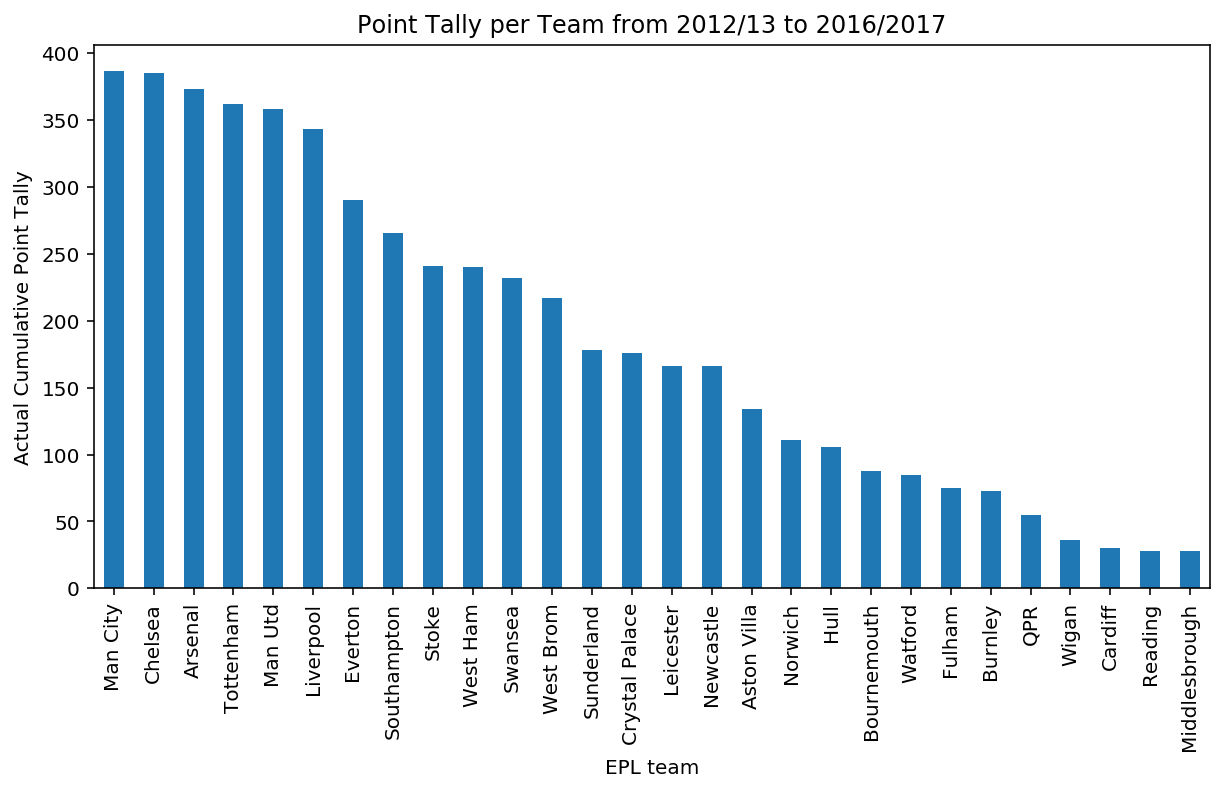

<Figure size 432x288 with 0 Axes>

In [18]:
%run league_table.py #../data/FootballEurope/FootballEurope.csv

# Modeling

In [23]:
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, f1_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_recall_fscore_support as PreRecF1Support_score
from sklearn.metrics import classification_report


from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import StandardScaler
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor

In [24]:
modeling_df = clean_df.copy()
y = modeling_df.pop('resultsLabel')
X = modeling_df.values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [ ]:
rfc = RandomForestClassifier(random_state=123)
param_grid = {'n_estimators': [50, 100, 150, 200, 300],
              'max_features': [0.2, 0.4, 0.6, 0.8, 'sqrt', 'log2'],
              'max_leaf_nodes': [None, 5, 7, 10],
              'min_samples_split': [2, 4, 6, 8],
              'min_samples_leaf': [2, 4, 8],
              'max_depth': [None, 3, 6, 10],
              'bootstrap': [True, False]}

rf_GS = GridSearchCV(RandomForestClassifier(),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='accuracy')
rf_GS.fit(X_train, y_train)
print("best RFClassifier parameters: ", rf_gridsearch.best_params_)
print("best RFClassifierModel Accuracy: ", rf_GS.score(X_test, y_test))
print("best RFClassifierModel: "rf_GS.best_estimator_
rf_opt = rf_GS.best_estimator_

In [ ]:
'''RandomForestClassifier(bootstrap=True, criterion='mse', max_depth=None,
           max_features=0.4, max_leaf_nodes=None, min_samples_leaf=4,
           min_samples_split=4, min_weight_fraction_leaf=0.0,
           n_estimators=150, n_jobs=-1, oob_score=False, random_state=123,
           verbose=True, warm_start=False)'''

# Clustering

In [25]:
clean_df.columns

Index(['awayDispossessedFT', 'awayPassSuccessFT', 'awayRatingsFT',
       'awayDribbleSuccessFT', 'homeFoulsCommitedFT', 'homeAerialsTotalFT',
       'awayShotsOnTargetFT', 'awayShotsBlockedFT', 'homePassesKeyFT',
       'awayDribblesWonFT', 'homeCornersTotalFT', 'homeShotsBlockedFT',
       'homeDribbleSuccessFT', 'awayAerialsTotalFT', 'awayPassesKeyFT',
       'homeFormation', 'refereeName', 'homePossessionFT',
       'awayInterceptionsFT', 'homeDribbledPastFT', 'homeDribblesWonFT',
       'awayTackleSuccessFT', 'awayTeam', 'homeDispossessedFT',
       'awayOffsidesCaughtFT', 'awayDribbledPastFT', 'awayFormation',
       'homeShotsTotalFT', 'homePassSuccessFT', 'awayCornersTotalFT',
       'homeTeam', 'awayFoulsCommitedFT', 'homeShotsOnTargetFT',
       'homeTacklesTotalFT', 'homeOffsidesCaughtFT', 'venueName',
       'awayDribblesAttemptedFT', 'homeInterceptionsFT', 'awayTacklesTotalFT',
       'homeRatingsFT', 'homeDribblesAttemptedFT', 'homeTackleSuccessFT',
       'awayPossession

In [227]:
data = clean_df.drop(['resultsLabel'], axis=1)

In [228]:
data = data[sorted(data.columns)]

In [229]:
data.head()

,awayAerialsTotalFT,awayCornersTotalFT,awayDispossessedFT,awayDribbleSuccessFT,awayDribbledPastFT,awayDribblesAttemptedFT,awayDribblesWonFT,awayFormation,awayFoulsCommitedFT,awayInterceptionsFT,awayOffsidesCaughtFT,awayPassSuccessFT,awayPassesKeyFT,awayPossessionFT,awayRatingsFT,awayShotsBlockedFT,awayShotsOnTargetFT,awayShotsTotalFT,awayTackleSuccessFT,awayTacklesTotalFT,awayTeam,homeAerialsTotalFT,homeCornersTotalFT,homeDispossessedFT,homeDribbleSuccessFT,homeDribbledPastFT,homeDribblesAttemptedFT,homeDribblesWonFT,homeFormation,homeFoulsCommitedFT,homeInterceptionsFT,homeOffsidesCaughtFT,homePassSuccessFT,homePassesKeyFT,homePossessionFT,homeRatingsFT,homeShotsBlockedFT,homeShotsOnTargetFT,homeShotsTotalFT,homeTackleSuccessFT,homeTacklesTotalFT,homeTeam,refereeName,venueName
0,22,4.0,14.0,47.22,5.0,20,10.0,0,11,34,5.0,73.69,9.0,52.35,6.38,4.0,2.0,11.0,75.00,18,13,22,7.0,6,38.89,10.0,12.0,5.0,2,12,21,2.0,66.73,14,47.65,6.73,4.0,10.0,21,75.00,34,1,17,7
1,15,6.0,11.0,27.27,4.0,11,3.0,2,10,11,2.0,75.78,6.0,46.29,6.39,4.0,5.0,11.0,86.96,26,7,15,8.0,13,31.82,3.0,13.0,4.0,2,12,14,3.0,80.95,7,53.71,6.37,4.0,2.0,10,88.89,22,2,9,12
2,19,5.0,16.0,66.67,5.0,9,6.0,2,8,15,2.0,74.86,11.0,60.18,6.73,5.0,6.0,15.0,73.53,20,9,19,3.0,9,45.00,6.0,11.0,5.0,2,12,5,4.0,69.70,16,39.82,6.04,6.0,6.0,19,75.00,25,3,16,26
3,36,3.0,6.0,27.78,8.0,18,5.0,2,10,24,4.0,78.43,8.0,54.02,6.41,3.0,2.0,11.0,63.54,23,2,36,3.0,9,63.33,5.0,14.0,8.0,2,11,23,1.0,64.96,10,45.98,6.43,3.0,5.0,14,79.55,24,3,10,26
4,48,4.0,9.0,40.00,16.0,16,6.0,3,14,19,3.0,61.07,5.0,46.80,6.51,2.0,4.0,8.0,61.61,37,11,48,14.0,13,66.18,6.0,24.0,16.0,2,10,7,1.0,77.44,13,53.20,6.45,4.0,4.0,16,71.93,25,4,0,20


In [230]:
data.columns[:21], data.columns[21:42]

(Index(['awayAerialsTotalFT', 'awayCornersTotalFT', 'awayDispossessedFT',
        'awayDribbleSuccessFT', 'awayDribbledPastFT', 'awayDribblesAttemptedFT',
        'awayDribblesWonFT', 'awayFormation', 'awayFoulsCommitedFT',
        'awayInterceptionsFT', 'awayOffsidesCaughtFT', 'awayPassSuccessFT',
        'awayPassesKeyFT', 'awayPossessionFT', 'awayRatingsFT',
        'awayShotsBlockedFT', 'awayShotsOnTargetFT', 'awayShotsTotalFT',
        'awayTackleSuccessFT', 'awayTacklesTotalFT', 'awayTeam'],
       dtype='object'),
 Index(['homeAerialsTotalFT', 'homeCornersTotalFT', 'homeDispossessedFT',
        'homeDribbleSuccessFT', 'homeDribbledPastFT', 'homeDribblesAttemptedFT',
        'homeDribblesWonFT', 'homeFormation', 'homeFoulsCommitedFT',
        'homeInterceptionsFT', 'homeOffsidesCaughtFT', 'homePassSuccessFT',
        'homePassesKeyFT', 'homePossessionFT', 'homeRatingsFT',
        'homeShotsBlockedFT', 'homeShotsOnTargetFT', 'homeShotsTotalFT',
        'homeTackleSuccessFT', 'home

In [231]:
away_cols = data.columns[:21]

home_cols = data.columns[21:42]

data_home = data.ix[:,home_cols]
data_away = data.ix[:,away_cols]
new_col = []
new_cols = []
for col in data_home.columns:
    new_col.append(col.split('home')[1:])
print(new_col)

for row in new_col:
    new_cols.append(row[0])
print(new_cols)

home_away_col = [item for sublist in new_col for item in sublist]
print()
print(home_away_col)

data_away.columns = new_cols
data_home.columns = new_cols

clust_data = data_home.append(data_away, ignore_index=True)

[['AerialsTotalFT'], ['CornersTotalFT'], ['DispossessedFT'], ['DribbleSuccessFT'], ['DribbledPastFT'], ['DribblesAttemptedFT'], ['DribblesWonFT'], ['Formation'], ['FoulsCommitedFT'], ['InterceptionsFT'], ['OffsidesCaughtFT'], ['PassSuccessFT'], ['PassesKeyFT'], ['PossessionFT'], ['RatingsFT'], ['ShotsBlockedFT'], ['ShotsOnTargetFT'], ['ShotsTotalFT'], ['TackleSuccessFT'], ['TacklesTotalFT'], ['Team']]
['AerialsTotalFT', 'CornersTotalFT', 'DispossessedFT', 'DribbleSuccessFT', 'DribbledPastFT', 'DribblesAttemptedFT', 'DribblesWonFT', 'Formation', 'FoulsCommitedFT', 'InterceptionsFT', 'OffsidesCaughtFT', 'PassSuccessFT', 'PassesKeyFT', 'PossessionFT', 'RatingsFT', 'ShotsBlockedFT', 'ShotsOnTargetFT', 'ShotsTotalFT', 'TackleSuccessFT', 'TacklesTotalFT', 'Team']

['AerialsTotalFT', 'CornersTotalFT', 'DispossessedFT', 'DribbleSuccessFT', 'DribbledPastFT', 'DribblesAttemptedFT', 'DribblesWonFT', 'Formation', 'FoulsCommitedFT', 'InterceptionsFT', 'OffsidesCaughtFT', 'PassSuccessFT', 'PassesKey

In [232]:
data_away.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,22,4.0,14.0,47.22,5.0,20,10.0,0,11,34,5.0,73.69,9.0,52.35,6.38,4.0,2.0,11.0,75.00,18,13
1,15,6.0,11.0,27.27,4.0,11,3.0,2,10,11,2.0,75.78,6.0,46.29,6.39,4.0,5.0,11.0,86.96,26,7
2,19,5.0,16.0,66.67,5.0,9,6.0,2,8,15,2.0,74.86,11.0,60.18,6.73,5.0,6.0,15.0,73.53,20,9
3,36,3.0,6.0,27.78,8.0,18,5.0,2,10,24,4.0,78.43,8.0,54.02,6.41,3.0,2.0,11.0,63.54,23,2
4,48,4.0,9.0,40.00,16.0,16,6.0,3,14,19,3.0,61.07,5.0,46.80,6.51,2.0,4.0,8.0,61.61,37,11


In [233]:
clust_data.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,22,7.0,6.0,38.89,10.0,12.0,5.0,2,12,21,2.0,66.73,14.0,47.65,6.73,4.0,10.0,21.0,75.00,34,1
1,15,8.0,13.0,31.82,3.0,13.0,4.0,2,12,14,3.0,80.95,7.0,53.71,6.37,4.0,2.0,10.0,88.89,22,2
2,19,3.0,9.0,45.00,6.0,11.0,5.0,2,12,5,4.0,69.70,16.0,39.82,6.04,6.0,6.0,19.0,75.00,25,3
3,36,3.0,9.0,63.33,5.0,14.0,8.0,2,11,23,1.0,64.96,10.0,45.98,6.43,3.0,5.0,14.0,79.55,24,3
4,48,14.0,13.0,66.18,6.0,24.0,16.0,2,10,7,1.0,77.44,13.0,53.20,6.45,4.0,4.0,16.0,71.93,25,4


In [234]:
norm_clust_data = (clust_data - clust_data.min())/ (clust_data.max() - clust_data.min())

In [235]:
norm_clust_data.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,0.15,0.368421,0.147059,0.3889,0.303030,0.244898,0.151515,0.5,0.458333,0.487179,0.181818,0.513062,0.388889,0.636827,0.609195,0.210526,0.588235,0.476190,0.653836,0.490909,0.000000
1,0.08,0.421053,0.352941,0.3182,0.090909,0.265306,0.121212,0.5,0.458333,0.307692,0.272727,0.792379,0.194444,0.718159,0.402299,0.210526,0.117647,0.214286,0.846164,0.272727,0.037037
2,0.12,0.157895,0.235294,0.4500,0.181818,0.224490,0.151515,0.5,0.458333,0.076923,0.363636,0.571401,0.444444,0.531741,0.212644,0.315789,0.352941,0.428571,0.653836,0.327273,0.074074
3,0.29,0.157895,0.235294,0.6333,0.151515,0.285714,0.242424,0.5,0.416667,0.538462,0.090909,0.478295,0.277778,0.614414,0.436782,0.157895,0.294118,0.309524,0.716837,0.309091,0.074074
4,0.41,0.736842,0.352941,0.6618,0.181818,0.489796,0.484848,0.5,0.375000,0.128205,0.090909,0.723434,0.361111,0.711314,0.448276,0.210526,0.235294,0.357143,0.611327,0.327273,0.111111


In [236]:
clust_data.shape, len(data_home.columns), len(new_cols)

((3800, 21), 21, 21)

In [237]:
n_clusters = 20
kmeans = KMeans(n_clusters, random_state=123)
kmeans.fit(clust_data.values)
y_pred = kmeans.predict(clust_data.values)
clust_kmeans = pd.DataFrame(kmeans.cluster_centers_, columns=clust_data.columns)

In [238]:
kmeans

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=123, tol=0.0001, verbose=0)

In [239]:
len(y_pred), len(clust_data), clust_data.shape

(3800, 3800, (3800, 21))

In [240]:
clust_data.mean()

AerialsTotalFT         35.017105
CornersTotalFT          5.397368
DispossessedFT         11.588947
DribbleSuccessFT       54.083679
DribbledPastFT          8.950789
DribblesAttemptedFT    16.239211
DribblesWonFT           8.950789
Formation               1.726842
FoulsCommitedFT        11.129737
InterceptionsFT        14.997105
OffsidesCaughtFT        2.115526
PassSuccessFT          67.506779
PassesKeyFT             9.908684
PossessionFT           40.099997
RatingsFT               6.455945
ShotsBlockedFT          3.564211
ShotsOnTargetFT         4.392105
ShotsTotalFT           13.206053
TackleSuccessFT        70.060913
TacklesTotalFT         27.810526
Team                   12.090000
dtype: float64

In [241]:
clust_kmeans.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,39.823232,29.079602,27.876106,46.453988,36.107407,27.511416,33.13200,47.176923,27.000000,27.793548,35.830508,21.582996,32.082927,51.890411,34.275676,23.730159,58.524590,46.649485,29.448276,45.956522
CornersTotalFT,7.055556,4.796020,7.283186,5.730061,4.548148,7.858447,3.96000,4.576923,4.529070,5.361290,6.644068,4.655870,4.663415,4.917808,3.594595,6.402116,5.158470,4.546392,4.645320,6.641304
DispossessedFT,12.212121,11.363184,11.247788,12.693252,11.585185,11.785388,10.28000,10.461538,13.023256,11.703226,11.525424,11.550607,14.151220,10.390411,11.027027,12.322751,10.469945,9.597938,10.921182,12.434783
DribbleSuccessFT,51.912121,51.305871,38.790664,76.606074,52.547148,65.725571,40.19984,68.649462,80.234535,76.779290,62.242825,50.778259,59.429854,29.303904,64.794000,56.282540,53.408087,37.394021,24.905419,50.622717
DribbledPastFT,9.500000,12.034826,5.278761,6.717791,5.837037,5.972603,12.84800,10.338462,9.372093,11.406452,5.581921,7.874494,12.629268,7.965753,12.572973,14.111111,9.464481,9.927835,7.049261,4.353261
DribblesAttemptedFT,18.525253,16.223881,18.367257,12.337423,13.585185,18.831050,15.78000,14.076923,12.947674,15.987097,18.892655,15.421053,23.746341,14.328767,12.756757,20.179894,15.797814,13.206186,12.123153,18.619565
DribblesWonFT,9.803030,8.656716,7.486726,9.263804,7.185185,12.310502,6.56800,9.638462,10.220930,12.116129,11.819209,7.967611,14.297561,4.616438,8.340541,11.608466,8.562842,5.360825,3.413793,9.679348
Formation,1.787879,1.298507,1.774336,1.852761,1.951852,1.694064,1.86000,1.461538,1.860465,1.380645,1.231638,1.696356,1.756098,1.890411,1.924324,1.767196,1.939891,1.463918,1.758621,1.847826
FoulsCommitedFT,10.469697,11.482587,10.384956,11.368098,11.911111,9.278539,12.07600,12.315385,10.337209,11.167742,10.683616,10.821862,11.302439,11.719178,11.837838,10.116402,11.857923,11.536082,11.674877,10.771739
InterceptionsFT,13.797980,14.258706,14.092920,14.085890,16.651852,12.552511,17.07200,13.261538,16.186047,13.767742,12.237288,16.287449,17.619512,15.308219,16.735135,15.095238,14.890710,13.432990,15.576355,14.021739


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


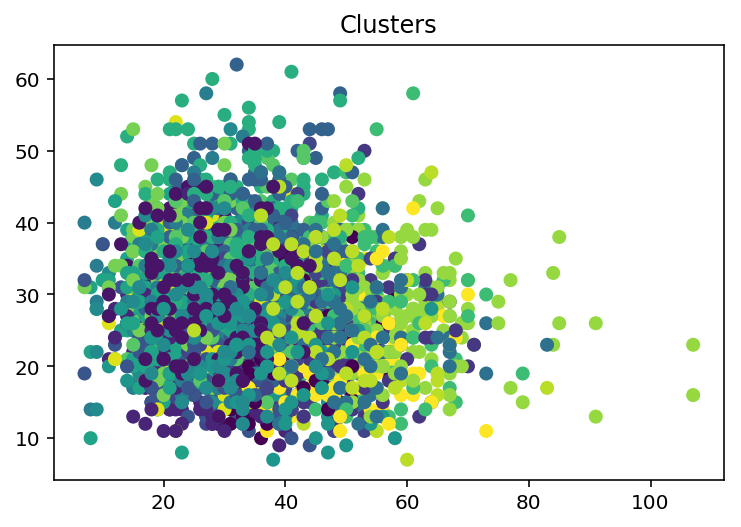

In [242]:
print(np.unique(y_pred))
print(np.unique(kmeans.labels_))
plt.scatter(clust_data.values[:, 0], clust_data.values[:, 19], c=y_pred)
plt.title("Clusters")

plt.show()

In [243]:
clust_stats = clust_data.describe(percentiles=[0.1, 0.35, 0.65, 0.9])
clust_stats

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,35.017105,5.397368,11.588947,54.083679,8.950789,16.239211,8.950789,1.726842,11.129737,14.997105,2.115526,67.506779,9.908684,40.099997,6.455945,3.564211,4.392105,13.206053,70.060913,27.810526,12.090000
std,12.296010,2.956737,4.387458,16.412515,4.353727,6.558574,4.353243,0.946928,3.459427,5.820220,1.602535,8.501967,4.533555,21.174401,0.206505,2.378190,2.463514,5.489986,11.061015,8.012158,7.648352
min,7.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,40.610000,0.000000,0.200000,5.670000,0.000000,0.000000,1.000000,27.780000,7.000000,1.000000
10%,20.000000,2.000000,6.000000,33.330000,4.000000,8.000000,4.000000,0.000000,7.000000,8.000000,0.000000,56.240000,5.000000,0.500000,6.200000,1.000000,2.000000,7.000000,55.668000,18.000000,2.900000
35%,30.000000,4.000000,10.000000,48.676500,7.000000,13.000000,7.000000,2.000000,10.000000,12.000000,1.000000,64.270000,8.000000,42.246500,6.380000,2.000000,3.000000,11.000000,65.910000,24.000000,8.000000
50%,34.000000,5.000000,11.000000,54.170000,8.000000,16.000000,8.000000,2.000000,11.000000,14.000000,2.000000,67.640000,9.000000,47.410000,6.450000,3.000000,4.000000,12.000000,70.450000,27.000000,11.000000
65%,38.000000,6.000000,13.000000,60.000000,10.000000,18.000000,10.000000,2.000000,12.000000,17.000000,2.000000,71.207000,11.000000,51.353500,6.520000,4.000000,5.000000,15.000000,74.640000,30.000000,14.350000
90%,51.000000,9.000000,18.000000,75.000000,15.000000,25.000000,15.000000,3.000000,16.000000,23.000000,4.000000,78.650000,16.000000,60.220000,6.730000,7.000000,8.000000,21.000000,84.215000,38.000000,23.100000
max,107.000000,19.000000,35.000000,100.000000,33.000000,49.000000,33.000000,4.000000,25.000000,41.000000,11.000000,91.520000,36.000000,74.710000,7.410000,19.000000,17.000000,43.000000,100.000000,62.000000,28.000000


In [244]:
clust_kmeans_exp = clust_kmeans.copy()
for col in clust_kmeans.columns:
    for i, row in enumerate(clust_kmeans[col]):
        #print(i, row)
        #print(i, col, clust_kmeans.ix[i,col])
        if clust_kmeans.ix[i,col] < clust_stats.ix['10%', col]:
            clust_kmeans_exp.ix[i,col] = 'V. Low'
        elif clust_kmeans.ix[i,col] < clust_stats.ix['35%', col]:
            clust_kmeans_exp.ix[i,col] = 'Low'
        elif clust_kmeans.ix[i,col] > clust_stats.ix['90%', col]:
            clust_kmeans_exp.ix[i,col] = 'V. High'
        elif clust_kmeans.ix[i,col] > clust_stats.ix['65%', col]:
            clust_kmeans_exp.ix[i,col] = 'High'
        else:
            clust_kmeans_exp.ix[i,col] = 'Medium'
clust_kmeans_exp = clust_kmeans_exp.T

In [245]:
'''
tactics = {0:'keep possession around middle', 1 :'defensive + long balls',
2 :'', 3 :'', 4 :'', 5: '', 6 :'ultradefensive + don\'t retain possesion + long balls', 
7 :'short passing + possession in opposition half', 8 :'', 9: ''}
'''

tactics = {0:'', 1 :'',
2 :'', 3 :'', 4 :'', 5: '', 6 :'', 
7 :'', 8 :'', 9: ''}

tactics2 = {0:'', 1 :'',2 :'', 3 :'', 4 :'', 5: '', 6 :'', 7 :'', 8 :'', 9: '',
           10:'', 11 :'',12 :'', 13 :'', 14 :'', 15: '', 16 :'', 17 :'', 18 :'', 19: ''}

clust_kmeans_exp.ix['Tactic', :] = tactics2

In [246]:
clust_kmeans_exp.columns

RangeIndex(start=0, stop=20, step=1)

In [247]:
clust_kmeans_exp

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,High,Low,Low,High,Medium,Low,Medium,High,Low,Low,Medium,Low,Medium,V. High,Medium,Low,V. High,High,Low,High
CornersTotalFT,High,Medium,High,Medium,Medium,High,Low,Medium,Medium,Medium,High,Medium,Medium,Medium,Low,High,Medium,Medium,Medium,High
DispossessedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Low,Medium,Medium
DribbleSuccessFT,Medium,Medium,Low,V. High,Medium,High,Low,High,V. High,V. High,High,Medium,Medium,V. Low,High,Medium,Medium,Low,V. Low,Medium
DribbledPastFT,Medium,High,Low,Low,Low,Low,High,High,Medium,High,Low,Medium,High,Medium,High,High,Medium,Medium,Medium,Low
DribblesAttemptedFT,High,Medium,High,Low,Medium,High,Medium,Medium,Low,Medium,High,Medium,High,Medium,Low,High,Medium,Medium,Low,High
DribblesWonFT,Medium,Medium,Medium,Medium,Medium,High,Low,Medium,High,High,High,Medium,High,Low,Medium,High,Medium,Low,V. Low,Medium
Formation,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Low,High,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium


In [248]:
clustV_Low = clust_kmeans_exp[clust_kmeans_exp == 'V. Low'].fillna('-')
clustLow = clust_kmeans_exp[clust_kmeans_exp == 'Low'].fillna('-')
clustV_High = clust_kmeans_exp[clust_kmeans_exp == 'V. High'].fillna('-')
clustHigh = clust_kmeans_exp[clust_kmeans_exp == 'High'].fillna('-')
clustMed = clust_kmeans_exp[clust_kmeans_exp == 'Medium'].fillna('-')

In [249]:
clustHigh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,High,-,-,High,-,-,-,High,-,-,-,-,-,-,-,-,-,High,-,High
CornersTotalFT,High,-,High,-,-,High,-,-,-,-,High,-,-,-,-,High,-,-,-,High
DispossessedFT,-,-,-,-,-,-,-,-,High,-,-,-,High,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,High,-,High,-,-,High,-,-,-,High,-,-,-,-,-
DribbledPastFT,-,High,-,-,-,-,High,High,-,High,-,-,High,-,High,High,-,-,-,-
DribblesAttemptedFT,High,-,High,-,-,High,-,-,-,-,High,-,High,-,-,High,-,-,-,High
DribblesWonFT,-,-,-,-,-,High,-,-,High,High,High,-,High,-,-,High,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,High,High,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,High,-,-,-,-,-,High,-,-,-,-,-,-,-


In [250]:
clustLow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,Low,Low,-,-,Low,-,-,Low,Low,-,Low,-,-,-,Low,-,-,Low,-
CornersTotalFT,-,-,-,-,-,-,Low,-,-,-,-,-,-,-,Low,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Low,-,-
DribbleSuccessFT,-,-,Low,-,-,-,Low,-,-,-,-,-,-,-,-,-,-,Low,-,-
DribbledPastFT,-,-,Low,Low,Low,Low,-,-,-,-,Low,-,-,-,-,-,-,-,-,Low
DribblesAttemptedFT,-,-,-,Low,-,-,-,-,Low,-,-,-,-,-,Low,-,-,-,Low,-
DribblesWonFT,-,-,-,-,-,-,Low,-,-,-,-,-,-,Low,-,-,-,Low,-,-
Formation,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
FoulsCommitedFT,-,-,-,-,-,Low,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [251]:
'''from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
visualizer = KElbowVisualizer(kmeans, k=(1,30))

visualizer.fit(clust_data)    # Fit the data to the visualizer
visualizer.poof()    # Draw/show/poof the data'''
2==2

True

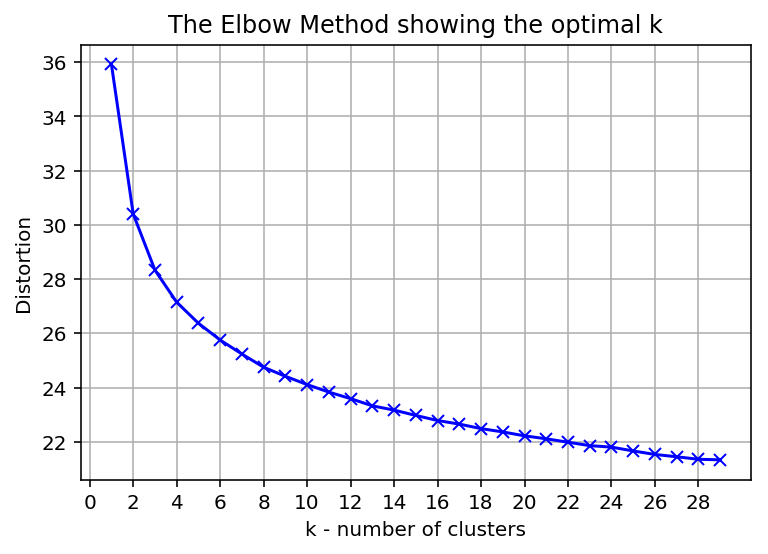

In [252]:

'''
n_clust = range(1,30)
kmeans_ = [KMeans(n_clusters=i).fit(clust_data) for i in n_clust]
score = [-1*(kmeans_[i].fit(clust_data).score(clust_data)) for i in range(len(kmeans_))]
score2 = [sum(np.min(cdist(clust_data, kmeans_[i].cluster_centers_, 'euclidean'), axis=1))/clust_data.shape[0] \
          for i in range(len(kmeans_))]
plt.grid(b=True, which='major', linestyle='-')
#plt.plot(n_clust, score)
plt.plot(n_clust, score2)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Score')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(np.arange(0, max(n_clust)+1, 2.0))
plt.show()
'''

# k means determine k 
distortions = []
K = range(1,30)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(clust_data)
    #print(np.min(cdist(clust_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1))
    distortions.append(sum(np.min(cdist(clust_data, \
                    kmeanModel.cluster_centers_, 'euclidean'), axis=1))/clust_data.shape[0])
#print(distortions)

# Plot the elbow
plt.grid(b=True, which='major', linestyle='-')
plt.plot(K, distortions, 'bx-')
plt.xlabel('k - number of clusters')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.xticks(np.arange(0, max(K)+1, 2.0))
plt.show()

In [253]:
len(kmeans.cluster_centers_), len(kmeans.labels_)

(20, 3800)

In [254]:
kmeans.labels_, np.unique(kmeans.labels_)

(array([11,  2, 11, ...,  9, 10, 17], dtype=int32),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19], dtype=int32))

In [255]:
from __future__ import print_function

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

#print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
Xblob, yblob = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1)  # For reproducibility

In [256]:
len(yblob), len(Xblob), Xblob.shape, type(yblob), type(Xblob)

(500, 500, (500, 2), numpy.ndarray, numpy.ndarray)

In [257]:
range_n_clusters = [5, 10, 15, 20]
def clusterplt(X):
    for n_clusters in range_n_clusters:

        # Initialize the clusterer with n_clusters value and a random generator
        # seed of 10 for reproducibility.
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)

        fig,ax2 = plt.subplots(1, 1)
        fig.set_size_inches(18, 7)
        
        # 2nd Plot showing the actual clusters formed
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        #ax2.set_title("The visualization of the clustered data.")
        ax2.set_title(("The visualization of the clustered data "
                      "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        '''plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')'''

    plt.show()

In [258]:
clust_data_array = clust_data.values

In [259]:
clust_data.tail(1)

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
3799,38,5.0,4.0,27.27,10.0,12.0,4.0,3,12,11,2.0,69.66,5.0,0.6,6.39,2.0,3.0,9.0,75.86,37,28


In [260]:
print(clust_data_array[-1:])
print(clust_data_array.shape, clust_data.shape)

[[38.    5.    4.   27.27 10.   12.    4.    3.   12.   11.    2.   69.66
   5.    0.6   6.39  2.    3.    9.   75.86 37.   28.  ]]
(3800, 21) (3800, 21)


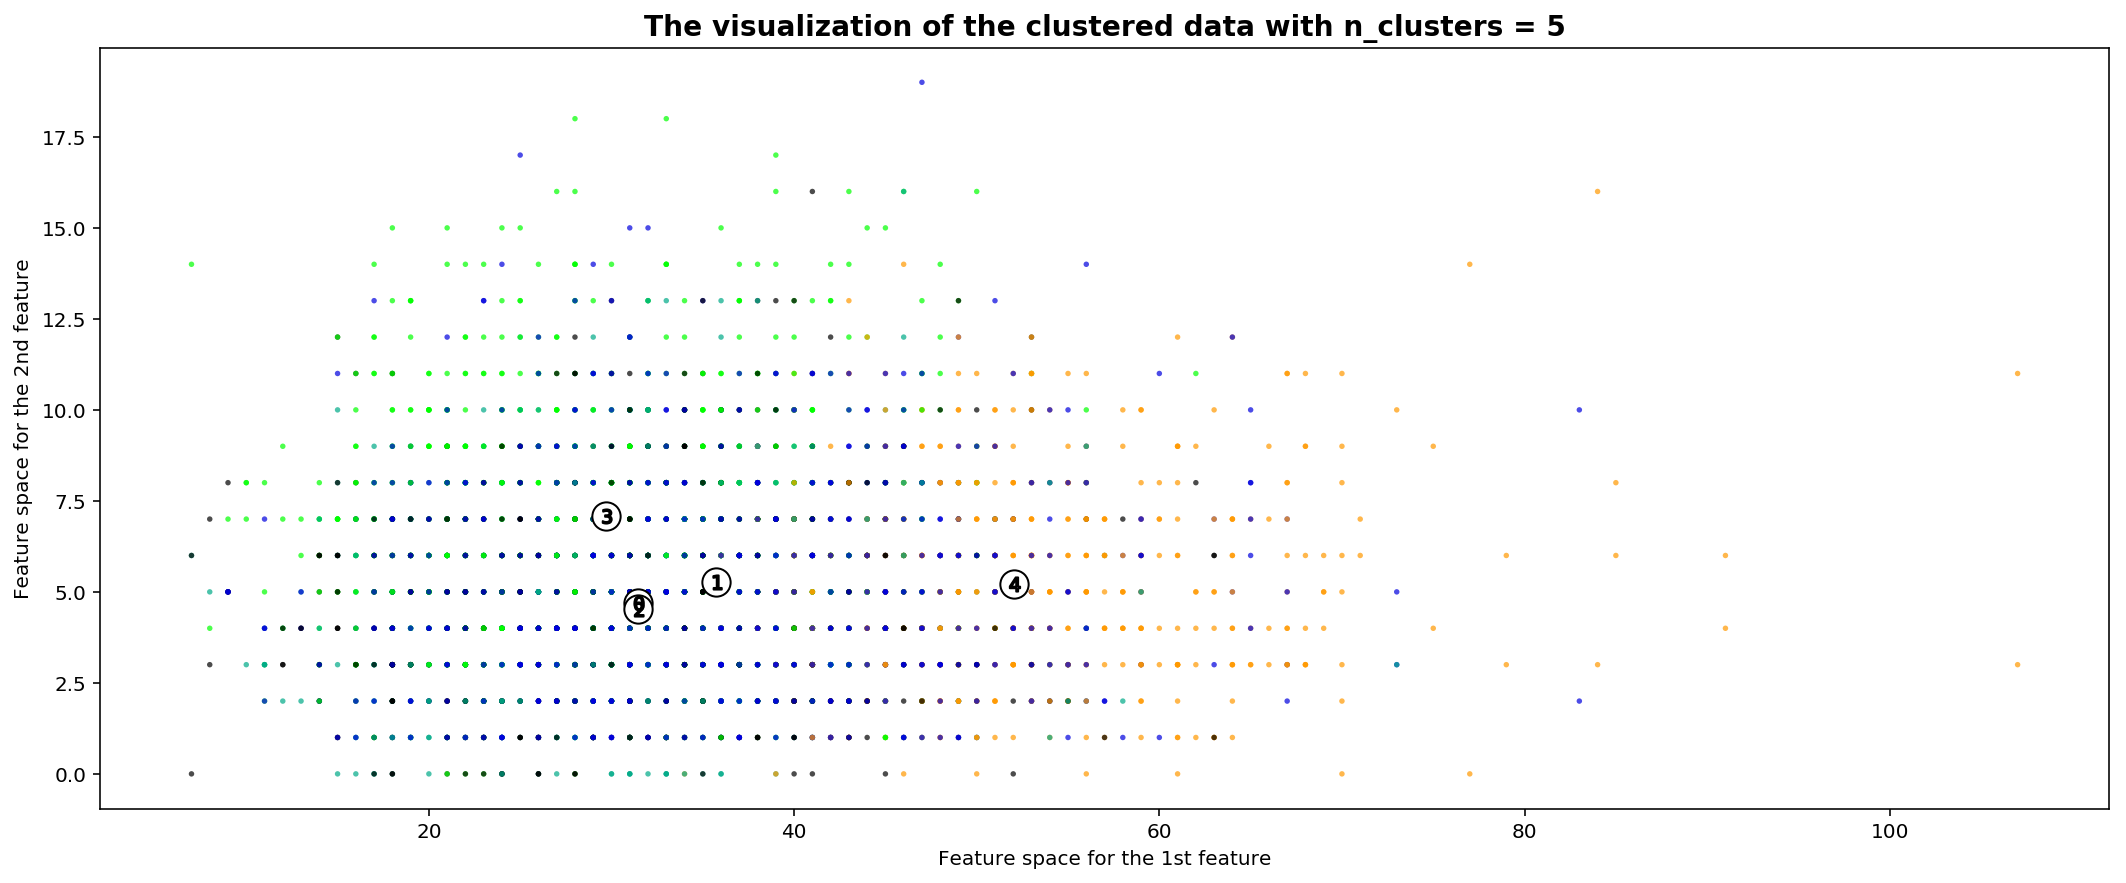

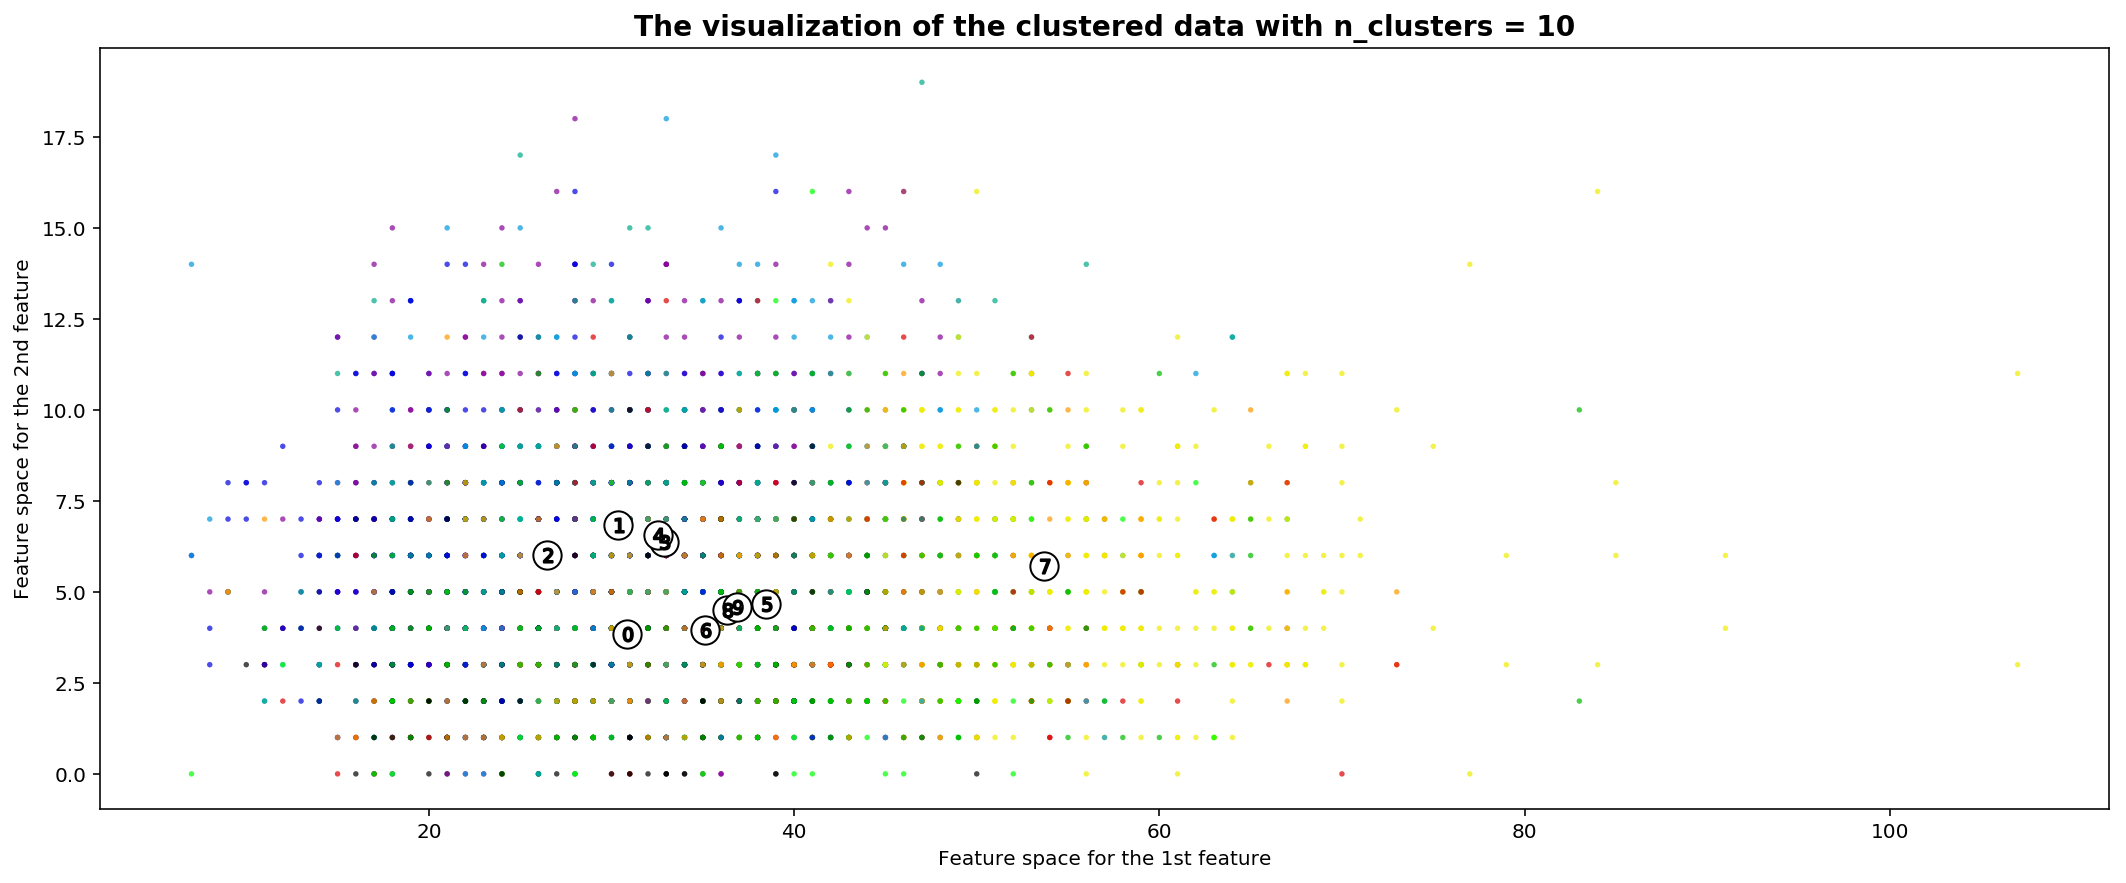

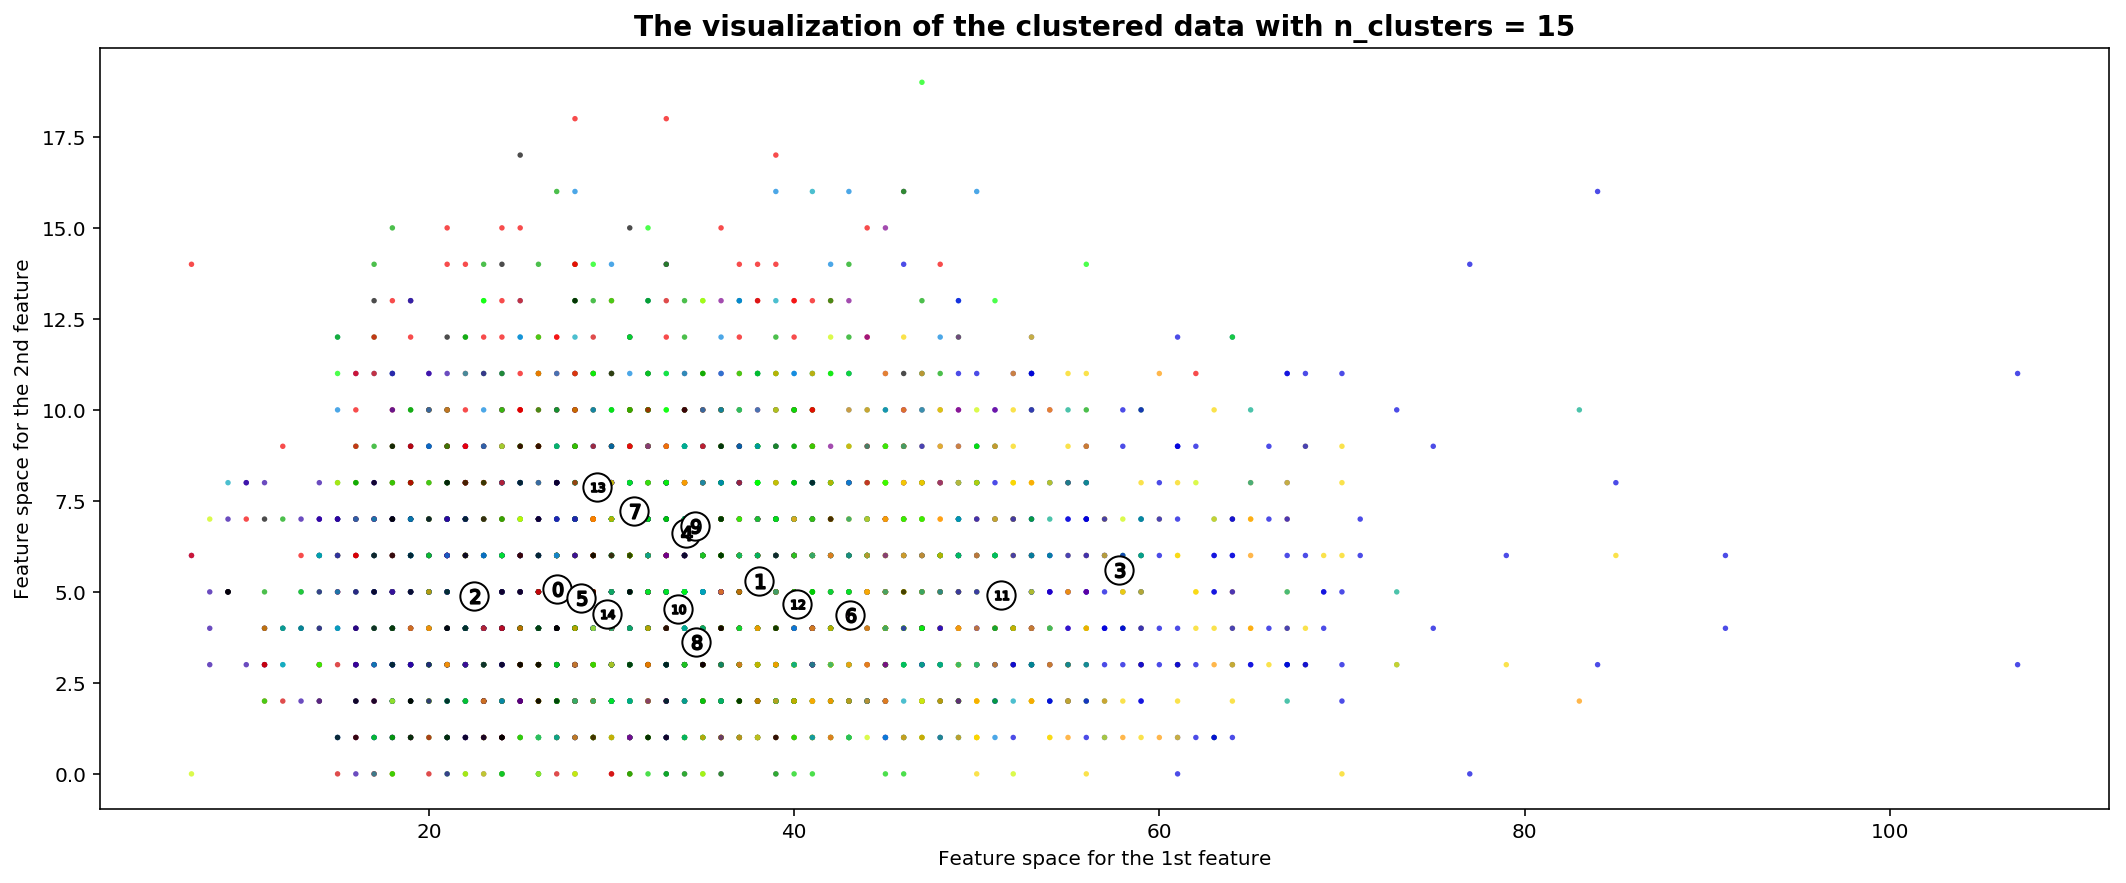

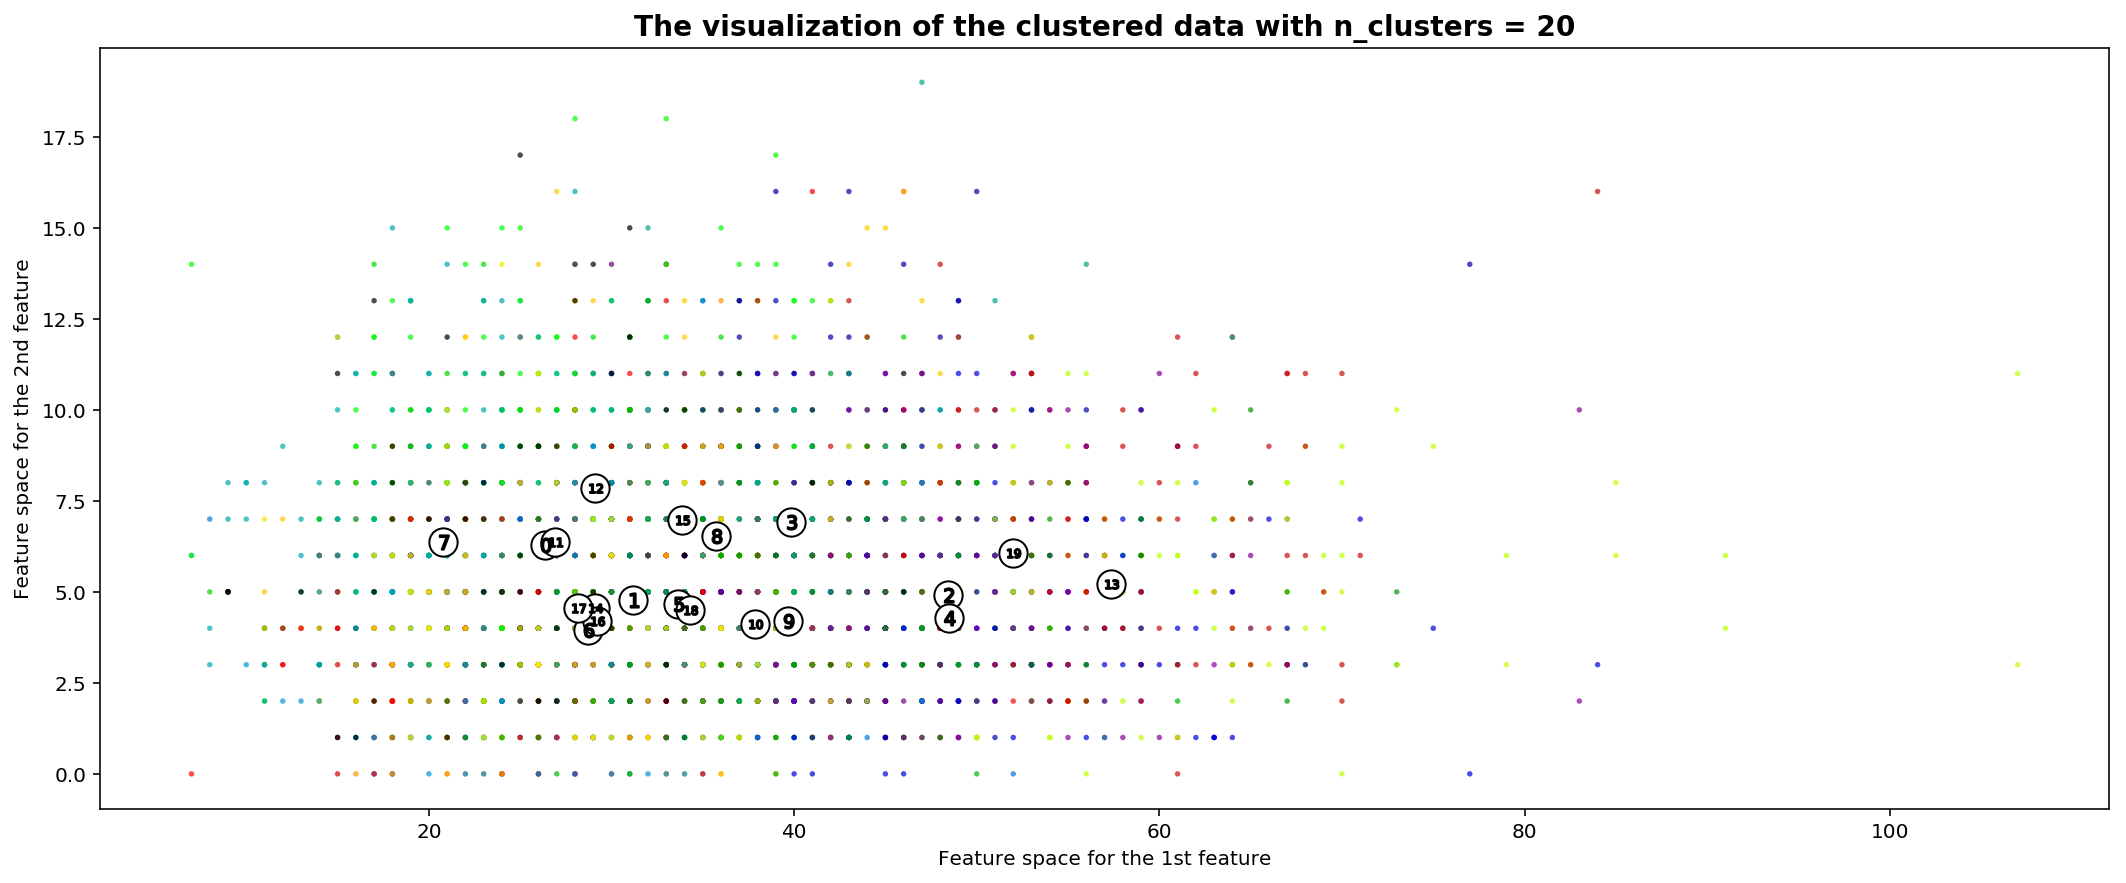

In [261]:
clusterplt(clust_data_array)

In [262]:
#print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

np.random.seed(42)


def bench_k_means(estimator, name, data):
    t0 = time()
    estimator.fit(data)
    print('%-9s\t%.2fs\t%.3f'
          % (name, (time() - t0),
             metrics.silhouette_score(data, estimator.labels_,
                                      metric='euclidean',
                                      sample_size=sample_size)))
    
def pca_kmeans_viz(data, n_clust=20, samples_size=300):
    '''K-means clustering on the EPL 2012-2017 soccer dataset (PCA-reduced data)
              Centroids are marked with white cross'''
    data = clust_data_array

    n_samples, n_features = data.shape
    n_digits = n_clust
    #labels = digits.target

    sample_size = samples_size

    print("n_digits: %d, \t n_samples: %d, \t sample_size: %d, \t n_features: %d"
          % (n_digits, n_samples, sample_size, n_features))


    print(82 * '_')
    print('init\t\ttime\tsilhouette')

    bench_k_means(KMeans(init='k-means++', n_clusters=n_digits, n_init=10),
                  name="k-means++", data=data)

    bench_k_means(KMeans(init='random', n_clusters=n_digits, n_init=10),
                  name="random", data=data)

    # in this case the seeding of the centers is deterministic, hence we run the
    # kmeans algorithm only once with n_init=1
    pca = PCA(n_components=n_digits).fit(data)
    bench_k_means(KMeans(init=pca.components_, n_clusters=n_digits, n_init=1),
                  name="PCA-based",
                  data=data)
    print(82 * '_')

    # #############################################################################
    # Visualize the results on PCA-reduced data

    reduced_data = PCA(n_components=2).fit_transform(data)
    kmeans = KMeans(init='k-means++', n_clusters=n_digits, n_init=10)
    kmeans.fit(reduced_data)

    # Step size of the mesh. Decrease to increase the quality of the VQ.
    h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

    # Plot the decision boundary. For that, we will assign a color to each
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1)
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('K-means clustering on the EPL 2012-2017 soccer dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()


n_digits: 20, 	 n_samples: 3800, 	 sample_size: 300, 	 n_features: 21
__________________________________________________________________________________
init		time	silhouette
k-means++	0.70s	0.089
random   	0.52s	0.077
PCA-based	0.04s	0.084
__________________________________________________________________________________


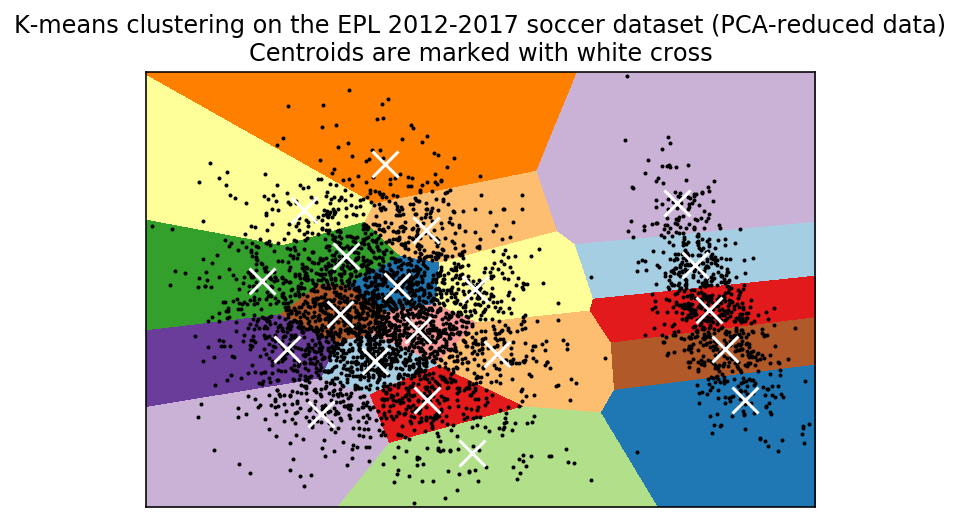

In [263]:
pca_kmeans_viz(clust_data_array)

n_digits: 5, 	 n_samples: 3800, 	 sample_size: 300, 	 n_features: 21
__________________________________________________________________________________
init		time	silhouette
k-means++	0.34s	0.145
random   	0.19s	0.154
PCA-based	0.02s	0.143
__________________________________________________________________________________


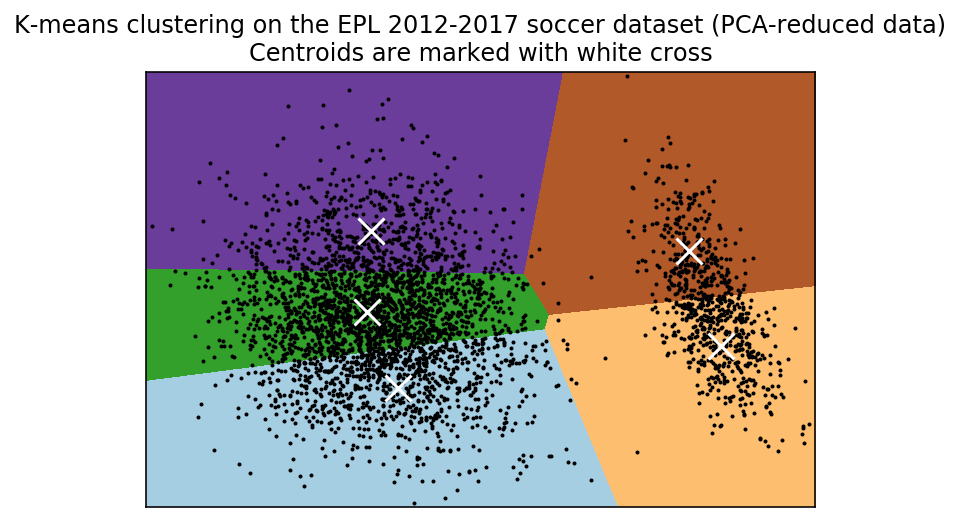

In [264]:
pca_kmeans_viz(clust_data_array, n_clust=5)

n_digits: 5, 	 n_samples: 3800, 	 sample_size: 300, 	 n_features: 21
__________________________________________________________________________________
init		time	silhouette
k-means++	0.28s	0.157
random   	0.21s	0.163
PCA-based	0.03s	0.157
__________________________________________________________________________________


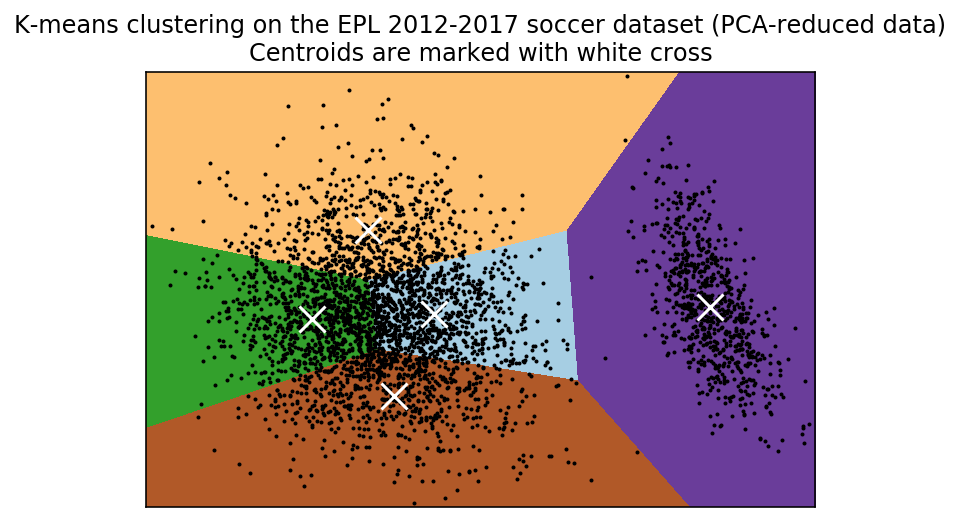

In [265]:
pca_kmeans_viz(data_home.values, n_clust=5)

n_digits: 5, 	 n_samples: 3800, 	 sample_size: 300, 	 n_features: 21
__________________________________________________________________________________
init		time	silhouette
k-means++	0.30s	0.157
random   	0.23s	0.160
PCA-based	0.02s	0.163
__________________________________________________________________________________


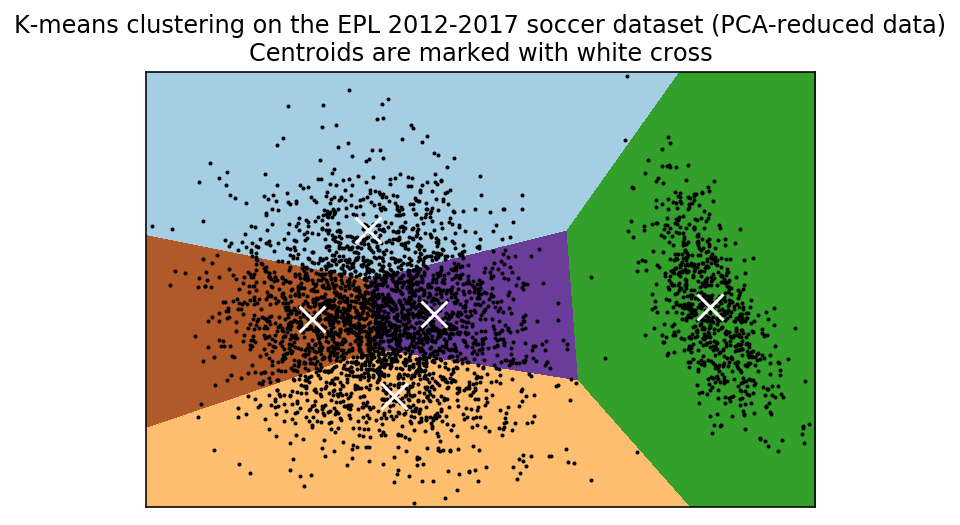

In [266]:
pca_kmeans_viz(data_away.values, n_clust=5)

In [165]:
def cluster_data_prep(ready_df):
    #ready_df = preprocessor.create_model_df('../data/FootballEurope/FootballEurope.csv')
    #ensure right dataframe input format
    data = ready_df.drop(['resultsLabel'], axis=1)
    data = data[sorted(data.columns)]
    away_cols = data.columns[:21]
    home_cols = data.columns[21:42]
    data_home = data.ix[:,home_cols]
    data_away = data.ix[:,away_cols]
    new_col = []
    new_cols = []
    for col in data_home.columns:
        new_col.append(col.split('home')[1:])
    #print(new_col)

    for row in new_col:
        new_cols.append(row[0])
    #print(new_cols)

    home_away_col = [item for sublist in new_col for item in sublist]
    #print()
    #print(home_away_col)

    data_away.columns = new_cols
    data_home.columns = new_cols

    clust_data = data_home.append(data_away, ignore_index=True)
    return clust_data, data_home, data_away


def tactical_clust_patterns(clust_data, n_clusters=20):
    kmeans = KMeans(n_clusters, random_state=123)
    kmeans.fit(clust_data.values)
    y_pred = kmeans.predict(clust_data.values)
    clust_kmeans = pd.DataFrame(kmeans.cluster_centers_, columns=clust_data.columns)
    clust_stats = clust_data.describe(percentiles=[0.1, 0.35, 0.65, 0.9])
    clust_kmeans_exp = clust_kmeans.copy()
    for col in clust_kmeans.columns:
        for i, row in enumerate(clust_kmeans[col]):
            #print(i, row)
            #print(i, col, clust_kmeans.ix[i,col])
            if clust_kmeans.ix[i,col] < clust_stats.ix['10%', col]:
                clust_kmeans_exp.ix[i,col] = 'V. Low'
            elif clust_kmeans.ix[i,col] < clust_stats.ix['35%', col]:
                clust_kmeans_exp.ix[i,col] = 'Low'
            elif clust_kmeans.ix[i,col] > clust_stats.ix['90%', col]:
                clust_kmeans_exp.ix[i,col] = 'V. High'
            elif clust_kmeans.ix[i,col] > clust_stats.ix['65%', col]:
                clust_kmeans_exp.ix[i,col] = 'High'
            else:
                clust_kmeans_exp.ix[i,col] = 'Medium'
    clust_kmeans_exp = clust_kmeans_exp.T
    tactics = {0:'', 1 :'',2 :'', 3 :'', 4 :'', 5: '', 6 :'', 7 :'', 8 :'', 9: '',
              10:'', 11 :'',12 :'', 13 :'', 14 :'', 15: '', 16 :'', 17 :'', 18 :'', 19: ''}

    clust_kmeans_exp.ix['Tactic', :] = tactics
    return clust_kmeans_exp

def percentiles_clusters(clust_kmeans_exp):
    clustV_Low = clust_kmeans_exp[clust_kmeans_exp == 'V. Low'].fillna('-')
    clustLow = clust_kmeans_exp[clust_kmeans_exp == 'Low'].fillna('-')
    clustV_High = clust_kmeans_exp[clust_kmeans_exp == 'V. High'].fillna('-')
    clustHigh = clust_kmeans_exp[clust_kmeans_exp == 'High'].fillna('-')
    clustMed = clust_kmeans_exp[clust_kmeans_exp == 'Medium'].fillna('-')
    return clustV_Low, clustLow, clustV_High, clustHigh, clustMed

def K_elbow_plot(clust_data):
    # k means determine k 
    distortions = []
    K = range(1,30)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(clust_data)
        #print(np.min(cdist(clust_data, kmeanModel.cluster_centers_, 'euclidean'), axis=1))
        distortions.append(sum(np.min(cdist(clust_data, \
                        kmeanModel.cluster_centers_, 'euclidean'), axis=1))/clust_data.shape[0])
    #print(distortions)

    # Plot the elbow
    plt.grid(b=True, which='major', linestyle='-')
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k - number of clusters')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.xticks(np.arange(0, max(K)+1, 2.0))
    plt.show()

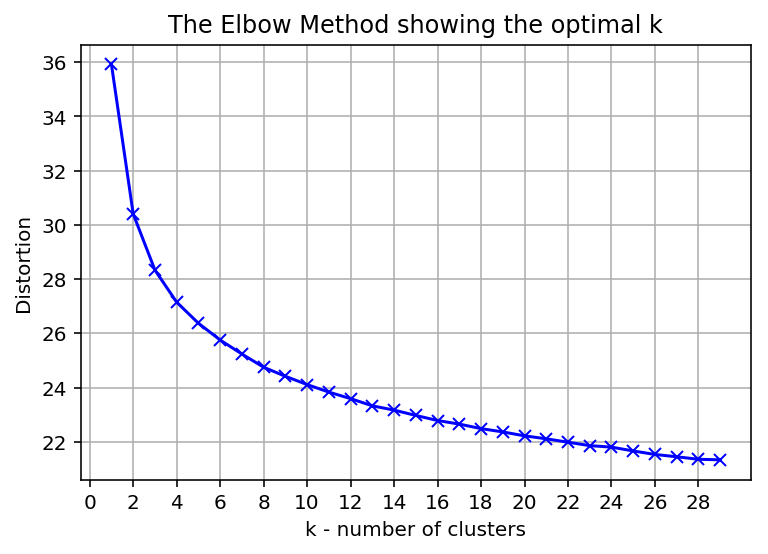

In [268]:
clusterData, homeData, awayData = cluster_data_prep(clean_df)
K_elbow_plot(clusterData)

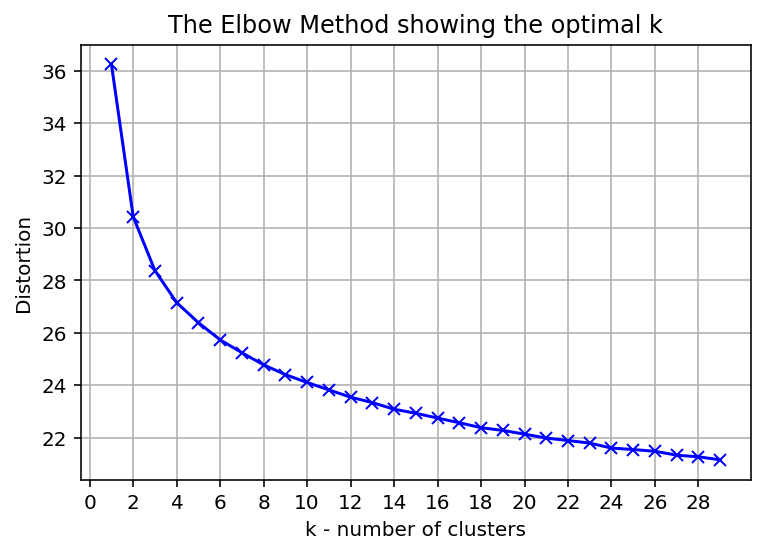

In [269]:
K_elbow_plot(homeData)

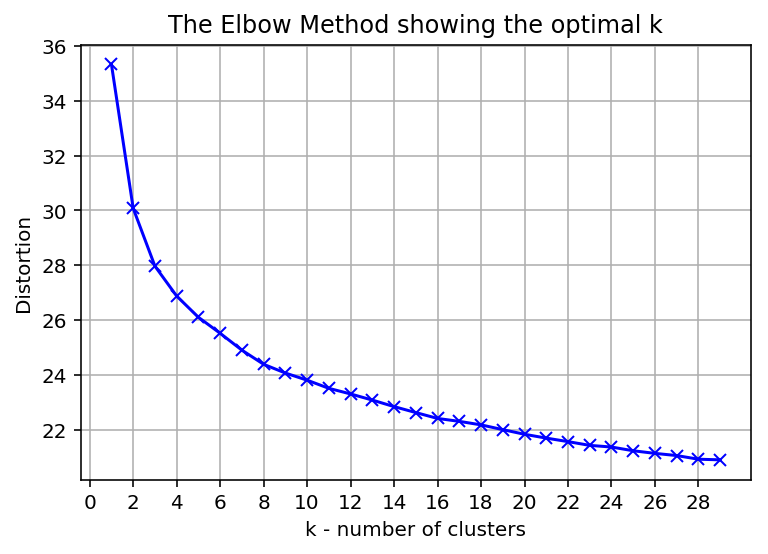

In [270]:
K_elbow_plot(awayData)

# Tactical Cluster Patterns (n=20)

In [271]:
clust_features = tactical_clust_patterns(clusterData, n_clusters=20)
cVLow, cLow, cVHigh, cHigh, cMed = percentiles_clusters(clust_features)

In [272]:
clust_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,High,Low,Low,High,Medium,Low,Medium,High,Low,Low,Medium,Low,Medium,V. High,Medium,Low,V. High,High,Low,High
CornersTotalFT,High,Medium,High,Medium,Medium,High,Low,Medium,Medium,Medium,High,Medium,Medium,Medium,Low,High,Medium,Medium,Medium,High
DispossessedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Low,Medium,Medium
DribbleSuccessFT,Medium,Medium,Low,V. High,Medium,High,Low,High,V. High,V. High,High,Medium,Medium,V. Low,High,Medium,Medium,Low,V. Low,Medium
DribbledPastFT,Medium,High,Low,Low,Low,Low,High,High,Medium,High,Low,Medium,High,Medium,High,High,Medium,Medium,Medium,Low
DribblesAttemptedFT,High,Medium,High,Low,Medium,High,Medium,Medium,Low,Medium,High,Medium,High,Medium,Low,High,Medium,Medium,Low,High
DribblesWonFT,Medium,Medium,Medium,Medium,Medium,High,Low,Medium,High,High,High,Medium,High,Low,Medium,High,Medium,Low,V. Low,Medium
Formation,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Low,High,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium


In [273]:
clust_home_features = tactical_clust_patterns(homeData, n_clusters=20)
c_h_VLow, c_h_Low, c_h_VHigh, c_h_High, c_h_Med = percentiles_clusters(clust_home_features)

In [274]:
clust_home_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,Low,Low,Medium,Medium,High,Medium,Medium,Low,High,Low,Medium,V. High,Medium,Medium,V. High,Low,Medium,High,Low,V. High
CornersTotalFT,High,High,Low,High,Medium,Medium,Medium,Medium,Medium,High,Low,Medium,Medium,Medium,Medium,Low,Low,Medium,High,Medium
DispossessedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium
DribbleSuccessFT,High,High,Medium,Medium,V. Low,V. High,Medium,Medium,Medium,High,High,Medium,Low,Low,Low,V. Low,High,High,Low,Medium
DribbledPastFT,High,Medium,High,Medium,Low,Medium,Low,High,Low,Low,High,Low,High,High,High,Medium,High,Medium,Low,High
DribblesAttemptedFT,High,High,Low,High,Medium,Low,Low,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium
DribblesWonFT,High,High,Medium,High,Low,Medium,Low,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Low,High,Medium,Low,Medium
Formation,Low,Low,Low,Low,Low,High,Low,Low,Low,Low,Low,High,Low,Low,Low,High,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Low,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Low,High,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium


In [275]:
clust_away_features = tactical_clust_patterns(awayData, n_clusters=20)
c_a_VLow, c_a_Low, c_a_VHigh, c_a_High, c_a_Med = percentiles_clusters(clust_away_features)

In [276]:
clust_away_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,Low,Low,High,Low,High,High,High,Medium,High,Low,Medium,Low,V. High,High,Low,Low,Medium,High,Low,Medium
CornersTotalFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium
DispossessedFT,Medium,Medium,Medium,Medium,Medium,Low,Medium,Low,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
DribbleSuccessFT,High,Medium,Medium,High,Medium,Low,V. Low,V. Low,V. High,Medium,Medium,Medium,Medium,Medium,High,Medium,High,V. High,V. Low,Low
DribbledPastFT,High,Medium,High,Medium,High,Medium,Low,High,Medium,Low,V. Low,High,Low,Medium,High,High,Low,Low,Low,High
DribblesAttemptedFT,High,Low,High,Medium,Medium,Low,Low,Medium,Medium,Medium,Medium,High,Medium,Medium,Low,High,High,Low,Medium,Medium
DribblesWonFT,High,Medium,High,High,Medium,Medium,V. Low,Low,High,Medium,Medium,High,Medium,Medium,Medium,High,High,Medium,Low,Medium
Formation,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,High,Low,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium


### 1) Home_away_aggregate

In [194]:
cVLow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,-,-,-,-,-,-,-,-,V. Low,-,-,-,-,V. Low,-
DribbledPastFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,V. Low,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [195]:
cLow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,Low,Low,-,-,Low,-,-,Low,Low,-,Low,-,-,-,Low,-,-,Low,-
CornersTotalFT,-,-,-,-,-,-,Low,-,-,-,-,-,-,-,Low,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,Low,-,-
DribbleSuccessFT,-,-,Low,-,-,-,Low,-,-,-,-,-,-,-,-,-,-,Low,-,-
DribbledPastFT,-,-,Low,Low,Low,Low,-,-,-,-,Low,-,-,-,-,-,-,-,-,Low
DribblesAttemptedFT,-,-,-,Low,-,-,-,-,Low,-,-,-,-,-,Low,-,-,-,Low,-
DribblesWonFT,-,-,-,-,-,-,Low,-,-,-,-,-,-,Low,-,-,-,Low,-,-
Formation,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
FoulsCommitedFT,-,-,-,-,-,Low,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [196]:
cVHigh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High,-,-,V. High,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,V. High,-,-,-,-,V. High,V. High,-,-,-,-,-,-,-,-,-,-
DribbledPastFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [197]:
cHigh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,High,-,-,High,-,-,-,High,-,-,-,-,-,-,-,-,-,High,-,High
CornersTotalFT,High,-,High,-,-,High,-,-,-,-,High,-,-,-,-,High,-,-,-,High
DispossessedFT,-,-,-,-,-,-,-,-,High,-,-,-,High,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,High,-,High,-,-,High,-,-,-,High,-,-,-,-,-
DribbledPastFT,-,High,-,-,-,-,High,High,-,High,-,-,High,-,High,High,-,-,-,-
DribblesAttemptedFT,High,-,High,-,-,High,-,-,-,-,High,-,High,-,-,High,-,-,-,High
DribblesWonFT,-,-,-,-,-,High,-,-,High,High,High,-,High,-,-,High,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,High,High,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,High,-,-,-,-,-,High,-,-,-,-,-,-,-


In [198]:
cMed

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,Medium,-,Medium,-,-,-,Medium,-,Medium,-,Medium,-,-,-,-,-
CornersTotalFT,-,Medium,-,Medium,Medium,-,-,Medium,Medium,Medium,-,Medium,Medium,Medium,-,-,Medium,Medium,Medium,-
DispossessedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium,-,Medium,Medium
DribbleSuccessFT,Medium,Medium,-,-,Medium,-,-,-,-,-,-,Medium,Medium,-,-,Medium,Medium,-,-,Medium
DribbledPastFT,Medium,-,-,-,-,-,-,-,Medium,-,-,Medium,-,Medium,-,-,Medium,Medium,Medium,-
DribblesAttemptedFT,-,Medium,-,-,Medium,-,Medium,Medium,-,Medium,-,Medium,-,Medium,-,-,Medium,Medium,-,-
DribblesWonFT,Medium,Medium,Medium,Medium,Medium,-,-,Medium,-,-,-,Medium,-,-,Medium,-,Medium,-,-,Medium
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,-,-,-,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium,Medium,Medium,Medium


### 2) Home


In [199]:
c_h_VLow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,V. Low,-,-,-,-,-,-,-,-,-,-,V. Low,-,-,-,-
DribbledPastFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [200]:
c_h_Low

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,Low,Low,-,-,-,-,-,Low,-,Low,-,-,-,-,-,Low,-,-,Low,-
CornersTotalFT,-,-,Low,-,-,-,-,-,-,-,Low,-,-,-,-,Low,Low,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,-,-,-,-,-,-,-,Low,Low,Low,-,-,-,Low,-
DribbledPastFT,-,-,-,-,Low,-,Low,-,Low,Low,-,Low,-,-,-,-,-,-,Low,-
DribblesAttemptedFT,-,-,Low,-,-,Low,Low,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,Low,-,Low,-,-,-,-,-,-,-,-,Low,-,-,Low,-
Formation,Low,Low,Low,Low,Low,-,Low,Low,Low,Low,Low,-,Low,Low,Low,-,Low,Low,Low,Low
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,Low,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,Low,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [201]:
c_h_VHigh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,V. High,-,-,V. High,-,-,-,-,V. High
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,V. High,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbledPastFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [202]:
c_h_High

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,High,-,-,-,High,-,-,-,-,-,-,-,-,High,-,-
CornersTotalFT,High,High,-,High,-,-,-,-,-,High,-,-,-,-,-,-,-,-,High,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,High,-,-,-
DribbleSuccessFT,High,High,-,-,-,-,-,-,-,High,High,-,-,-,-,-,High,High,-,-
DribbledPastFT,High,-,High,-,-,-,-,High,-,-,High,-,High,High,High,-,High,-,-,High
DribblesAttemptedFT,High,High,-,High,-,-,-,High,-,-,-,-,-,-,-,-,High,-,-,-
DribblesWonFT,High,High,-,High,-,-,-,-,-,High,-,-,-,-,-,-,High,-,-,-
Formation,-,-,-,-,-,High,-,-,-,-,-,High,-,-,-,High,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,High,-,-,-,-,High,-,-,-,-,-,-,-,-,High,-,-,-


In [203]:
c_h_Med

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,Medium,Medium,-,Medium,Medium,-,-,-,Medium,-,Medium,Medium,-,-,Medium,-,-,-
CornersTotalFT,-,-,-,-,Medium,Medium,Medium,Medium,Medium,-,-,Medium,Medium,Medium,Medium,-,-,Medium,-,Medium
DispossessedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium
DribbleSuccessFT,-,-,Medium,Medium,-,-,Medium,Medium,Medium,-,-,Medium,-,-,-,-,-,-,-,Medium
DribbledPastFT,-,Medium,-,Medium,-,Medium,-,-,-,-,-,-,-,-,-,Medium,-,Medium,-,-
DribblesAttemptedFT,-,-,-,-,Medium,-,-,-,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium
DribblesWonFT,-,-,Medium,-,-,Medium,-,Medium,Medium,-,Medium,Medium,Medium,Medium,Medium,-,-,Medium,-,Medium
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,-,-,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium


### 3) Away


In [204]:
c_a_VLow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,-,V. Low,V. Low,-,-,-,-,-,-,-,-,-,-,V. Low,-
DribbledPastFT,-,-,-,-,-,-,-,-,-,-,V. Low,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,V. Low,-,-,-,-,-,-,-,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [205]:
c_a_Low

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,Low,Low,-,Low,-,-,-,-,-,Low,-,Low,-,-,Low,Low,-,-,Low,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,Low,-,Low,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,Low,-,-,-,-,-,-,-,-,-,-,-,-,-,Low
DribbledPastFT,-,-,-,-,-,-,Low,-,-,Low,-,-,Low,-,-,-,Low,Low,Low,-
DribblesAttemptedFT,-,Low,-,-,-,Low,Low,-,-,-,-,-,-,-,Low,-,-,Low,-,-
DribblesWonFT,-,-,-,-,-,-,-,Low,-,-,-,-,-,-,-,-,-,-,Low,-
Formation,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low,Low
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,Low,-,-,-,-,-,-,-,-,-


In [206]:
c_a_VHigh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,V. High,-,-,-,-,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,-,-,-,V. High,-,-,-,-,-,-,-,-,V. High,-,-
DribbledPastFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [207]:
c_a_High

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,High,-,High,High,High,-,High,-,-,-,-,High,-,-,-,High,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,High,-,-,-,-,High,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,High,-,-,-,-,-,-,-,-
DribbleSuccessFT,High,-,-,High,-,-,-,-,-,-,-,-,-,-,High,-,High,-,-,-
DribbledPastFT,High,-,High,-,High,-,-,High,-,-,-,High,-,-,High,High,-,-,-,High
DribblesAttemptedFT,High,-,High,-,-,-,-,-,-,-,-,High,-,-,-,High,High,-,-,-
DribblesWonFT,High,-,High,High,-,-,-,-,High,-,-,High,-,-,-,High,High,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,High,-,-,-,-,-,-,High,-,-,-,-,-,-,-,-,-,-


In [208]:
c_a_Med

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,Medium,-,-,Medium,-,-,-,-,-,Medium,-,-,Medium
CornersTotalFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium
DispossessedFT,Medium,Medium,Medium,Medium,Medium,-,Medium,-,Medium,Medium,Medium,-,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
DribbleSuccessFT,-,Medium,Medium,-,Medium,-,-,-,-,Medium,Medium,Medium,Medium,Medium,-,Medium,-,-,-,-
DribbledPastFT,-,Medium,-,Medium,-,Medium,-,-,Medium,-,-,-,-,Medium,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,Medium,Medium,-,-,Medium,Medium,Medium,Medium,-,Medium,Medium,-,-,-,-,Medium,Medium
DribblesWonFT,-,Medium,-,-,Medium,Medium,-,-,-,Medium,Medium,-,Medium,Medium,Medium,-,-,Medium,-,Medium
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,-,Medium,Medium,Medium,Medium,Medium,Medium,-,-,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium


# Tactical Cluster Patterns (n=5)

In [267]:
clust5_features = tactical_clust_patterns(clusterData, n_clusters=5)
c5VLow, c5Low, c5VHigh, c5High, c5Med = percentiles_clusters(clust_features)
clust5_features

,0,1,2,3,4
AerialsTotalFT,Medium,Medium,Medium,V. High,Low
CornersTotalFT,Medium,Medium,Medium,Medium,High
DispossessedFT,Medium,Medium,Medium,Medium,Medium
DribbleSuccessFT,High,Low,High,Medium,Medium
DribbledPastFT,Medium,Medium,High,Medium,Medium
DribblesAttemptedFT,Medium,Medium,Medium,Medium,High
DribblesWonFT,Medium,Low,High,Medium,High
Formation,Low,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,Medium


In [277]:
clust5_home_features = tactical_clust_patterns(homeData, n_clusters=5)
c5_h_VLow, c5_h_Low, c5_h_VHigh, c5_h_High, c5_h_Med = percentiles_clusters(clust5_home_features)
clust5_home_features

,0,1,2,3,4
AerialsTotalFT,Medium,Medium,Low,Medium,V. High
CornersTotalFT,Medium,Medium,High,Medium,Medium
DispossessedFT,Medium,Medium,Medium,Medium,Medium
DribbleSuccessFT,High,Low,Medium,High,Medium
DribbledPastFT,Medium,Medium,Medium,High,Medium
DribblesAttemptedFT,Medium,Medium,High,Medium,Medium
DribblesWonFT,Medium,Low,Medium,Medium,Medium
Formation,Low,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,Medium


In [278]:
clust5_away_features = tactical_clust_patterns(awayData, n_clusters=5)
c5_a_VLow, c5_a_Low, c5_a_VHigh, c5_a_High, c5_a_Med = percentiles_clusters(clust5_away_features)
clust5_away_features

,0,1,2,3,4
AerialsTotalFT,Medium,Medium,V. High,Low,Medium
CornersTotalFT,Medium,Medium,Medium,Medium,Medium
DispossessedFT,Medium,Medium,Medium,Medium,Medium
DribbleSuccessFT,Medium,High,Medium,Medium,Low
DribbledPastFT,Medium,High,Medium,Medium,Medium
DribblesAttemptedFT,Medium,Medium,Medium,Medium,Medium
DribblesWonFT,Medium,High,Medium,Medium,Low
Formation,Low,Low,Low,Low,Low
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,Medium


In [357]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize

scaler = StandardScaler().fit(clust_data)
clust_data_scaled = scaler.transform(clust_data)
c_d_s_df = pd.DataFrame(clust_data_scaled, columns=clust_data.columns)

minmax = MinMaxScaler().fit(clust_data)
clust_data_minmax_scaled = minmax.transform(clust_data)
c_d_MMs_df = pd.DataFrame(clust_data_minmax_scaled, columns=clust_data.columns)

c_d_norm_df = pd.DataFrame(normalize(clust_data), columns=clust_data.columns)

/Users/CEO/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/CEO/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/Users/CEO/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [358]:
clust_data.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,22,7.0,6.0,38.89,10.0,12.0,5.0,2,12,21,2.0,66.73,14.0,47.65,6.73,4.0,10.0,21.0,75.00,34,1
1,15,8.0,13.0,31.82,3.0,13.0,4.0,2,12,14,3.0,80.95,7.0,53.71,6.37,4.0,2.0,10.0,88.89,22,2
2,19,3.0,9.0,45.00,6.0,11.0,5.0,2,12,5,4.0,69.70,16.0,39.82,6.04,6.0,6.0,19.0,75.00,25,3
3,36,3.0,9.0,63.33,5.0,14.0,8.0,2,11,23,1.0,64.96,10.0,45.98,6.43,3.0,5.0,14.0,79.55,24,3
4,48,14.0,13.0,66.18,6.0,24.0,16.0,2,10,7,1.0,77.44,13.0,53.20,6.45,4.0,4.0,16.0,71.93,25,4


In [359]:
c_d_s_df.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,-1.058784,0.542098,-1.274014,-0.925859,0.241023,-0.646447,-0.907670,0.288505,0.251596,1.031522,-0.072099,-0.091377,0.902571,0.356610,1.327290,0.183268,2.276680,1.419853,0.446590,0.772612,-1.450176
1,-1.628149,0.880354,0.321653,-1.356685,-1.367007,-0.493954,-1.137414,0.288505,0.251596,-0.171340,0.551994,1.581398,-0.641675,0.642842,-0.416243,0.183268,-0.971141,-0.584059,1.702517,-0.725309,-1.319412
2,-1.302798,-0.810922,-0.590157,-0.553533,-0.677851,-0.798939,-0.907670,0.288505,0.251596,-1.717877,1.176088,0.258000,1.343784,-0.013225,-2.014481,1.024355,0.652769,1.055505,0.446590,-0.350829,-1.188648
3,0.079947,-0.810922,-0.590157,0.563444,-0.907569,-0.341462,-0.218438,0.288505,-0.037507,1.375197,-0.696193,-0.299591,0.020145,0.277730,-0.125654,-0.237275,0.246792,0.144636,0.857999,-0.475656,-1.188648
4,1.056001,2.909885,0.321653,0.737115,-0.677851,1.183460,1.619514,0.288505,-0.326611,-1.374202,-0.696193,1.168498,0.681964,0.618753,-0.028791,0.183268,-0.159186,0.508984,0.169002,-0.350829,-1.057883


In [360]:
c_d_MMs_df.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,0.15,0.368421,0.147059,0.3889,0.303030,0.244898,0.151515,0.5,0.458333,0.487179,0.181818,0.513062,0.388889,0.636827,0.609195,0.210526,0.588235,0.476190,0.653836,0.490909,0.000000
1,0.08,0.421053,0.352941,0.3182,0.090909,0.265306,0.121212,0.5,0.458333,0.307692,0.272727,0.792379,0.194444,0.718159,0.402299,0.210526,0.117647,0.214286,0.846164,0.272727,0.037037
2,0.12,0.157895,0.235294,0.4500,0.181818,0.224490,0.151515,0.5,0.458333,0.076923,0.363636,0.571401,0.444444,0.531741,0.212644,0.315789,0.352941,0.428571,0.653836,0.327273,0.074074
3,0.29,0.157895,0.235294,0.6333,0.151515,0.285714,0.242424,0.5,0.416667,0.538462,0.090909,0.478295,0.277778,0.614414,0.436782,0.157895,0.294118,0.309524,0.716837,0.309091,0.074074
4,0.41,0.736842,0.352941,0.6618,0.181818,0.489796,0.484848,0.5,0.375000,0.128205,0.090909,0.723434,0.361111,0.711314,0.448276,0.210526,0.235294,0.357143,0.611327,0.327273,0.111111


In [361]:
c_d_norm_df.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,0.167519,0.053302,0.045687,0.296128,0.076145,0.091374,0.038073,0.015229,0.091374,0.159905,0.015229,0.508116,0.106603,0.362831,0.051246,0.030458,0.076145,0.159905,0.571088,0.258893,0.007615
1,0.105923,0.056492,0.091800,0.224697,0.021185,0.091800,0.028246,0.014123,0.084738,0.098861,0.021185,0.571629,0.049431,0.379274,0.044982,0.028246,0.014123,0.070615,0.627697,0.155353,0.014123
2,0.148933,0.023516,0.070547,0.352736,0.047031,0.086224,0.039193,0.015677,0.094063,0.039193,0.031354,0.546348,0.125417,0.312132,0.047345,0.047031,0.047031,0.148933,0.587893,0.195964,0.023516
3,0.254844,0.021237,0.063711,0.448313,0.035395,0.099106,0.056632,0.014158,0.077869,0.162817,0.007079,0.459852,0.070790,0.325492,0.045518,0.021237,0.035395,0.099106,0.563135,0.169896,0.021237
4,0.315057,0.091892,0.085328,0.434385,0.039382,0.157529,0.105019,0.013127,0.065637,0.045946,0.006564,0.508292,0.085328,0.349188,0.042336,0.026255,0.026255,0.105019,0.472126,0.164092,0.026255


In [363]:
c_d_norm_df - c_d_MMs_df

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
0,0.017519,-0.315120,-0.101372,-0.092772,-0.226885,-0.153524,-0.113443,-0.484771,-0.366959,-0.327275,-0.166589,-0.004947,-0.282286,-0.273996,-0.557950,-0.180068,-0.512090,-0.316286,-0.082748,-0.232016,0.007615
1,0.025923,-0.364561,-0.261142,-0.093503,-0.069725,-0.173507,-0.092966,-0.485877,-0.373595,-0.208831,-0.251543,-0.220750,-0.145014,-0.338885,-0.357317,-0.182280,-0.103524,-0.143671,-0.218467,-0.117374,-0.022914
2,0.028933,-0.134379,-0.164747,-0.097264,-0.134787,-0.138266,-0.112322,-0.484323,-0.364271,-0.037730,-0.332282,-0.025052,-0.319027,-0.219609,-0.165299,-0.268758,-0.305910,-0.279639,-0.065943,-0.131309,-0.050558
3,-0.035156,-0.136658,-0.171583,-0.184987,-0.116120,-0.186608,-0.185792,-0.485842,-0.338798,-0.375645,-0.083830,-0.018443,-0.206988,-0.288922,-0.391264,-0.136658,-0.258723,-0.210418,-0.153703,-0.139195,-0.052837
4,-0.094943,-0.644950,-0.267613,-0.227415,-0.142436,-0.332267,-0.379829,-0.486873,-0.309363,-0.082259,-0.084345,-0.215141,-0.275783,-0.362125,-0.405940,-0.184272,-0.209039,-0.252124,-0.139200,-0.163180,-0.084856
5,0.016542,-0.044611,-0.462597,-0.053299,-0.334244,-0.173433,-0.089132,-0.725940,-0.261153,-0.265895,-0.497334,0.036065,-0.177819,-0.247919,-0.436215,-0.089223,-0.203214,-0.165664,0.009198,-0.299520,-0.108048
6,-0.004604,-0.268955,-0.143436,-0.086212,-0.202475,-0.189036,-0.134984,0.000000,-0.364664,-0.180576,-0.166207,0.104285,-0.239664,-0.239839,-0.477296,-0.224129,-0.306107,-0.200243,-0.084050,-0.225513,-0.138351
7,0.018782,-0.407945,-0.213770,-0.134783,-0.137992,-0.183454,-0.160991,-0.485391,-0.370681,-0.297115,-0.167210,-0.109050,-0.368522,-0.291039,-0.520319,-0.407945,-0.463673,-0.372315,-0.098225,-0.133787,-0.171092
8,-0.084089,-0.410876,-0.284652,-0.117501,-0.093298,-0.134295,-0.093298,-0.729064,-0.235838,-0.284641,-0.083930,-0.049404,-0.395184,-0.354675,-0.596293,-0.091306,-0.622139,-0.329639,-0.173362,-0.096791,-0.203430
9,0.002167,-0.321032,-0.197007,-0.144517,-0.070600,-0.286404,-0.235332,-0.486460,-0.132817,-0.212914,-0.252418,-0.277184,-0.357135,-0.410819,-0.444366,-0.366894,-0.364376,-0.299944,-0.186929,-0.032495,-0.235368


In [350]:
c_d_norm_df.describe()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,Formation,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsOnTargetFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team
count,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000,3800.000000
mean,0.015306,0.014228,0.015172,0.015523,0.014588,0.015042,0.014589,0.014224,0.015491,0.015123,0.012932,0.016095,0.014752,0.014345,0.016214,0.013495,0.014149,0.014980,0.016024,0.015588,0.013710
std,0.005375,0.007794,0.005744,0.004711,0.007096,0.006075,0.007095,0.007800,0.004815,0.005869,0.009796,0.002027,0.006749,0.007575,0.000519,0.009004,0.007936,0.006227,0.002530,0.004491,0.008673
min,0.003060,0.000000,0.001309,0.000000,0.000000,0.000000,0.000000,0.000000,0.001392,0.002017,0.000000,0.009682,0.000000,0.000072,0.014240,0.000000,0.000000,0.001134,0.006354,0.003924,0.001134
25%,0.011365,0.007908,0.010473,0.012557,0.009779,0.011115,0.009779,0.008237,0.012527,0.011093,0.006113,0.014660,0.010421,0.013262,0.015872,0.007572,0.009664,0.010209,0.014326,0.012331,0.006804
50%,0.014862,0.013180,0.014401,0.015548,0.013039,0.014820,0.013039,0.016474,0.015311,0.014118,0.012225,0.016127,0.013399,0.016961,0.016199,0.011358,0.012886,0.013612,0.016113,0.015134,0.012474
75%,0.018358,0.018452,0.018328,0.018657,0.019558,0.018526,0.019558,0.016474,0.018094,0.019160,0.018338,0.017614,0.019354,0.019347,0.016525,0.018931,0.019329,0.018149,0.017789,0.018497,0.021545
max,0.046770,0.050085,0.045820,0.028702,0.053785,0.045388,0.053786,0.032949,0.034797,0.041345,0.067240,0.021820,0.053596,0.026727,0.018610,0.071937,0.054765,0.048775,0.022871,0.034752,0.031751


In [351]:
norm_clust_feat = tactical_clust_patterns(c_d_norm_df, n_clusters=20)
norm_clust_feat_percentiles = percentiles_clusters(norm_clust_feat)
norm_clust_feat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Low,High,Medium,High,Medium,Medium,Medium,High,Medium,Medium,Medium
CornersTotalFT,Medium,High,Medium,High,Medium,Medium,Low,Medium,High,Medium,Medium,High,Low,Medium,High,Medium,High,V. High,Low,Low
DispossessedFT,High,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium
DribbleSuccessFT,Medium,Medium,Low,Medium,Medium,Medium,Low,Medium,Medium,Medium,Medium,Medium,Medium,Low,High,High,Medium,Medium,Medium,Low
DribbledPastFT,High,Medium,Medium,Low,Medium,Medium,Medium,V. High,Low,Medium,High,Medium,Medium,Low,Medium,Medium,High,Medium,High,Medium
DribblesAttemptedFT,Medium,Medium,Low,Medium,V. High,Medium,Low,Medium,Medium,Medium,Medium,V. High,Medium,Low,High,Medium,High,High,High,Low
DribblesWonFT,Medium,Medium,Low,Medium,V. High,Medium,Low,Medium,Medium,Medium,Medium,V. High,Medium,Low,High,Medium,High,High,High,Low
Formation,Low,High,High,Low,Low,Low,High,Low,Low,Low,High,Low,Low,High,Low,Low,Low,Low,High,High
FoulsCommitedFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Low,Medium,Medium,Medium,Medium,Medium,Low,Medium,Medium
InterceptionsFT,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Low,Medium,Medium,Medium,High,Medium


In [352]:
scaled_clust_feat = tactical_clust_patterns(c_d_s_df, n_clusters=20)
scaled_clust_feat_percentiles = percentiles_clusters(scaled_clust_feat)
scaled_clust_feat

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,Medium,Medium,Low,Medium,Medium,High,Medium,Medium,High,V. High,Medium,Medium,Low,Medium,Medium,Medium,Medium,Medium,Medium,Medium
CornersTotalFT,Medium,High,High,Low,Medium,Medium,Low,Low,Medium,Medium,Medium,Medium,Medium,Medium,Medium,V. High,V. High,High,Medium,Medium
DispossessedFT,High,Medium,Medium,Medium,Medium,Low,Medium,Medium,Medium,Low,Medium,Low,Medium,Medium,Medium,Medium,Medium,Medium,V. High,Medium
DribbleSuccessFT,High,High,Medium,Low,Medium,High,V. Low,High,High,Medium,Medium,Medium,Medium,High,High,Medium,High,Low,Medium,Medium
DribbledPastFT,Low,Medium,High,V. High,Low,High,Medium,High,Low,Medium,Medium,Medium,Medium,High,High,Low,Medium,Low,High,Medium
DribblesAttemptedFT,Low,High,Medium,Medium,High,Medium,Low,Low,Medium,Medium,Medium,Medium,Medium,V. High,Medium,Medium,High,Medium,Medium,High
DribblesWonFT,Low,High,Medium,Medium,High,Medium,V. Low,Low,High,Medium,Medium,Low,Medium,V. High,Medium,Medium,High,Low,Medium,Medium
Formation,High,Low,Low,Low,Low,Low,High,High,Low,High,Low,Low,Low,Low,Low,Low,Low,Low,Low,High
FoulsCommitedFT,Medium,Medium,Medium,High,Medium,High,Medium,Medium,Medium,High,Medium,High,Medium,Medium,Medium,Low,Low,Medium,High,Medium
InterceptionsFT,Medium,Low,Medium,High,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,Medium,High,Medium,Medium,Medium,Medium,Medium,V. High


In [353]:
norm_clust_feat_percentiles[2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbledPastFT,-,-,-,-,-,-,-,V. High,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,V. High,-,-,-,-,-,-,V. High,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,V. High,-,-,-,-,-,-,V. High,-,-,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [354]:
scaled_clust_feat_percentiles[2]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,V. High,-,-,-,-,-,-,-,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High,V. High,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High,-
DribbleSuccessFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbledPastFT,-,-,-,V. High,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High


In [347]:
cVHigh

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AerialsTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,V. High,-,-,V. High,-,-,-
CornersTotalFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DispossessedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribbleSuccessFT,-,-,-,V. High,-,-,-,-,V. High,V. High,-,-,-,-,-,-,-,-,-,-
DribbledPastFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesAttemptedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
DribblesWonFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Formation,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
FoulsCommitedFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
InterceptionsFT,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-


In [324]:
data.head()

,awayAerialsTotalFT,awayCornersTotalFT,awayDispossessedFT,awayDribbleSuccessFT,awayDribbledPastFT,awayDribblesAttemptedFT,awayDribblesWonFT,awayFormation,awayFoulsCommitedFT,awayInterceptionsFT,awayOffsidesCaughtFT,awayPassSuccessFT,awayPassesKeyFT,awayPossessionFT,awayRatingsFT,awayShotsBlockedFT,awayShotsOnTargetFT,awayShotsTotalFT,awayTackleSuccessFT,awayTacklesTotalFT,awayTeam,homeAerialsTotalFT,homeCornersTotalFT,homeDispossessedFT,homeDribbleSuccessFT,homeDribbledPastFT,homeDribblesAttemptedFT,homeDribblesWonFT,homeFormation,homeFoulsCommitedFT,homeInterceptionsFT,homeOffsidesCaughtFT,homePassSuccessFT,homePassesKeyFT,homePossessionFT,homeRatingsFT,homeShotsBlockedFT,homeShotsOnTargetFT,homeShotsTotalFT,homeTackleSuccessFT,homeTacklesTotalFT,homeTeam,refereeName,venueName
0,22,4.0,14.0,47.22,5.0,20,10.0,0,11,34,5.0,73.69,9.0,52.35,6.38,4.0,2.0,11.0,75.00,18,13,22,7.0,6,38.89,10.0,12.0,5.0,2,12,21,2.0,66.73,14,47.65,6.73,4.0,10.0,21,75.00,34,1,17,7
1,15,6.0,11.0,27.27,4.0,11,3.0,2,10,11,2.0,75.78,6.0,46.29,6.39,4.0,5.0,11.0,86.96,26,7,15,8.0,13,31.82,3.0,13.0,4.0,2,12,14,3.0,80.95,7,53.71,6.37,4.0,2.0,10,88.89,22,2,9,12
2,19,5.0,16.0,66.67,5.0,9,6.0,2,8,15,2.0,74.86,11.0,60.18,6.73,5.0,6.0,15.0,73.53,20,9,19,3.0,9,45.00,6.0,11.0,5.0,2,12,5,4.0,69.70,16,39.82,6.04,6.0,6.0,19,75.00,25,3,16,26
3,36,3.0,6.0,27.78,8.0,18,5.0,2,10,24,4.0,78.43,8.0,54.02,6.41,3.0,2.0,11.0,63.54,23,2,36,3.0,9,63.33,5.0,14.0,8.0,2,11,23,1.0,64.96,10,45.98,6.43,3.0,5.0,14,79.55,24,3,10,26
4,48,4.0,9.0,40.00,16.0,16,6.0,3,14,19,3.0,61.07,5.0,46.80,6.51,2.0,4.0,8.0,61.61,37,11,48,14.0,13,66.18,6.0,24.0,16.0,2,10,7,1.0,77.44,13,53.20,6.45,4.0,4.0,16,71.93,25,4,0,20


In [327]:
data.columns[:21]

Index(['awayAerialsTotalFT', 'awayCornersTotalFT', 'awayDispossessedFT',
       'awayDribbleSuccessFT', 'awayDribbledPastFT', 'awayDribblesAttemptedFT',
       'awayDribblesWonFT', 'awayFormation', 'awayFoulsCommitedFT',
       'awayInterceptionsFT', 'awayOffsidesCaughtFT', 'awayPassSuccessFT',
       'awayPassesKeyFT', 'awayPossessionFT', 'awayRatingsFT',
       'awayShotsBlockedFT', 'awayShotsOnTargetFT', 'awayShotsTotalFT',
       'awayTackleSuccessFT', 'awayTacklesTotalFT', 'awayTeam'],
      dtype='object')

In [328]:
data_mod = pd.DataFrame()
for col in data.columns[0:21]:
    if (col != 'awayFormation') & (col!= 'awayShotsOnTargetFT'):
        away_stat = data[col].copy()
        home_stat = data[col.replace('away', 'home')].copy()
        home_stat[home_stat==0] = 0.0001
        away_stat[away_stat==0] = 0.0001
        data_mod[col.replace('away', '')] = home_stat/away_stat
data_mod['home_formation'] = data['homeFormation'].copy()
data_mod['away_formation'] = data['awayFormation'].copy()
#data_mod['League'] = data['League'].copy()

In [329]:
data_mod.head()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team,home_formation,away_formation
0,1.0,1.750000,0.428571,0.823592,2.000,0.600000,0.500000,1.090909,0.617647,0.400000,0.905550,1.555556,0.910220,1.054859,1.0,1.909091,1.000000,1.888889,0.076923,2,0
1,1.0,1.333333,1.181818,1.166850,0.750,1.181818,1.333333,1.200000,1.272727,1.500000,1.068224,1.166667,1.160294,0.996870,1.0,0.909091,1.022194,0.846154,0.285714,2,2
2,1.0,0.600000,0.562500,0.674966,1.200,1.222222,0.833333,1.500000,0.333333,2.000000,0.931071,1.454545,0.661682,0.897474,1.2,1.266667,1.019992,1.250000,0.333333,2,2
3,1.0,1.000000,1.500000,2.279698,0.625,0.777778,1.600000,1.100000,0.958333,0.250000,0.828254,1.250000,0.851166,1.003120,1.0,1.272727,1.251967,1.043478,1.500000,2,2
4,1.0,3.500000,1.444444,1.654500,0.375,1.500000,2.666667,0.714286,0.368421,0.333333,1.268053,2.600000,1.136752,0.990783,2.0,2.000000,1.167505,0.675676,0.363636,2,3


In [330]:
data_mod.describe()

,AerialsTotalFT,CornersTotalFT,DispossessedFT,DribbleSuccessFT,DribbledPastFT,DribblesAttemptedFT,DribblesWonFT,FoulsCommitedFT,InterceptionsFT,OffsidesCaughtFT,PassSuccessFT,PassesKeyFT,PossessionFT,RatingsFT,ShotsBlockedFT,ShotsTotalFT,TackleSuccessFT,TacklesTotalFT,Team,home_formation,away_formation
count,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000,1900.000000
mean,0.999852,1522.950277,1.148250,911.655719,295.912652,1.333496,90.956334,1.053390,1.161240,3137.954297,1.061280,80.752008,1.140558,1.012280,3206.941065,1.700741,1.041093,1.027685,2.155314,1.718947,1.734737
std,0.002720,12261.268440,0.727787,20336.853380,5373.546691,1.074732,2604.760250,0.553549,0.765676,10326.200623,0.218461,3441.195219,0.448847,0.060745,14443.503954,1.919407,0.227129,0.414671,3.496412,0.923600,0.969875
min,0.928571,0.000007,0.083333,0.000001,0.000010,0.000007,0.000007,0.090909,0.100000,0.000014,0.552571,0.062500,0.250000,0.822785,0.000008,0.045455,0.412044,0.187500,0.035714,0.000000,0.000000
25%,1.000000,0.714286,0.705882,0.764919,0.571429,0.757500,0.692308,0.700000,0.687500,0.500000,0.899252,0.769231,0.822988,0.973956,0.666667,0.797368,0.887515,0.741935,0.444444,1.000000,1.000000
50%,1.000000,1.250000,1.000000,1.002845,0.894444,1.093074,1.118056,0.923077,1.000000,1.000000,1.034177,1.285714,1.044990,1.009449,1.250000,1.272727,1.024677,0.959167,1.000661,2.000000,2.000000
75%,1.000000,2.333333,1.400000,1.321907,1.444444,1.637987,1.750000,1.285714,1.428571,2.000000,1.200541,2.142857,1.374310,1.048789,2.666667,2.000000,1.167261,1.231410,2.250000,2.000000,2.000000
max,1.033333,160000.000000,11.000000,562500.000000,140000.000000,23.000000,100000.000000,10.000000,11.333333,90000.000000,2.174388,150000.000000,3.347826,1.268836,140000.000000,39.000000,1.988300,3.866667,28.000000,4.000000,4.000000
